In [1]:
import pandas as pd
from binance.client import Client
import matplotlib.pyplot as plt
import numpy as np
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.impute import SimpleImputer


In [2]:
# Initialize the Binance client
api_key = 'your_api_key'
api_secret = 'your_api_secret'
client = Client(api_key, api_secret)

# Get historical data for BTCUSDT
klines = client.get_historical_klines("BTCUSDT", Client.KLINE_INTERVAL_1DAY, "1 Jan, 2010", "28 Feb, 2025")

# Create a DataFrame
df = pd.DataFrame(klines, columns=['timestamp', 'open', 'high', 'low', 'close', 'volume', 'close_time', 'quote_asset_volume', 'number_of_trades', 'taker_buy_base_asset_volume', 'taker_buy_quote_asset_volume', 'ignore'])

# Convert timestamp to datetime
df['timestamp'] = pd.to_datetime(df['timestamp'], unit='ms')

# Set timestamp as index
df.set_index('timestamp', inplace=True)

btc = df[['open', 'close', 'volume']].copy()
print(btc.head())

                     open          close         volume
timestamp                                              
2017-08-17  4261.48000000  4285.08000000   795.15037700
2017-08-18  4285.08000000  4108.37000000  1199.88826400
2017-08-19  4108.37000000  4139.98000000   381.30976300
2017-08-20  4120.98000000  4086.29000000   467.08302200
2017-08-21  4069.13000000  4016.00000000   691.74306000


In [3]:
for _ in range(1, 101):
    btc[f'close_{_}'] = btc['close'].shift(_)
    btc[f'volume_{_}'] = btc['volume'].shift(_)

btc['day'] = range(1, len(btc) + 1)

print(btc.head())

                     open          close         volume        close_1  \
timestamp                                                                
2017-08-17  4261.48000000  4285.08000000   795.15037700           None   
2017-08-18  4285.08000000  4108.37000000  1199.88826400  4285.08000000   
2017-08-19  4108.37000000  4139.98000000   381.30976300  4108.37000000   
2017-08-20  4120.98000000  4086.29000000   467.08302200  4139.98000000   
2017-08-21  4069.13000000  4016.00000000   691.74306000  4086.29000000   

                 volume_1        close_2       volume_2        close_3  \
timestamp                                                                
2017-08-17           None           None           None           None   
2017-08-18   795.15037700           None           None           None   
2017-08-19  1199.88826400  4285.08000000   795.15037700           None   
2017-08-20   381.30976300  4108.37000000  1199.88826400  4285.08000000   
2017-08-21   467.08302200  4139.98000

C:\Users\isaac\AppData\Local\Temp\ipykernel_10932\3470102768.py:3: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  btc[f'volume_{_}'] = btc['volume'].shift(_)
C:\Users\isaac\AppData\Local\Temp\ipykernel_10932\3470102768.py:2: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  btc[f'close_{_}'] = btc['close'].shift(_)
C:\Users\isaac\AppData\Local\Temp\ipykernel_10932\3470102768.py:3: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider

In [4]:
btc_cleaned = btc.dropna()
print(btc_cleaned.head(-10))

                      open           close          volume         close_1  \
timestamp                                                                    
2017-11-25   8138.99000000   8700.01000000   4292.62368200   8138.00000000   
2017-11-26   8700.04000000   9128.02000000   4147.38023700   8700.01000000   
2017-11-27   9128.00000000   9650.00000000   4521.62570700   9128.02000000   
2017-11-28   9650.00000000   9896.80000000   4917.21098500   9650.00000000   
2017-11-29   9896.79000000   9687.88000000  13352.53871500   9896.80000000   
...                    ...             ...             ...             ...   
2025-02-14  96608.13000000  97500.48000000  18173.02646000  96608.14000000   
2025-02-15  97500.47000000  97569.66000000   7349.37683000  97500.48000000   
2025-02-16  97569.67000000  96118.12000000   8191.42490000  97569.66000000   
2025-02-17  96118.12000000  95780.00000000  16492.04510000  96118.12000000   
2025-02-18  95780.01000000  95671.74000000  23368.19471000  9578

In [5]:
# Calculate the indices for splitting the data
train_size = int(len(btc) * 0.6)
validate_size = int(len(btc) * 0.2)

# Split the data
train = btc[:train_size]
validate = btc[train_size:train_size + validate_size]
test = btc[train_size + validate_size:]

# Define the columns for train_x and train_y
x_columns = [f'close_{i}' for i in range(1, 101)] + ['day']
y_column = 'close'

# Separate train_x and train_y
train_x = train[x_columns]
train_y = train[y_column]

# Separate validate_x and validate_y
validate_x = validate[x_columns]
validate_y = validate[y_column]

# Separate test_x and test_y
test_x = test[x_columns]
test_y = test[y_column]

train_x.info()
train_y.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1651 entries, 2017-08-17 to 2022-02-22
Columns: 101 entries, close_1 to day
dtypes: int64(1), object(100)
memory usage: 1.3+ MB
<class 'pandas.core.series.Series'>
DatetimeIndex: 1651 entries, 2017-08-17 to 2022-02-22
Series name: close
Non-Null Count  Dtype 
--------------  ----- 
1651 non-null   object
dtypes: object(1)
memory usage: 25.8+ KB


In [6]:
# Initialize the imputer
imputer = SimpleImputer(strategy='mean')

# Fit the imputer on the training data and transform
train_x_imputed = imputer.fit_transform(train_x)
validate_x_imputed = imputer.transform(validate_x)

# Initialize the model
model = LinearRegression()

# Fit the model on the training data
model.fit(train_x_imputed, train_y)

# Predict on the training data
train_predictions = model.predict(train_x_imputed)

# Calculate the mean squared error on the training data
train_mse = mean_squared_error(train_y, train_predictions)

# Predict on the validation data
validate_predictions = model.predict(validate_x_imputed)

# Calculate the mean squared error on the validation data
validate_mse = mean_squared_error(validate_y, validate_predictions)

print(f'Training Mean Squared Error: {train_mse}')
print(f'Validation Mean Squared Error: {validate_mse}')

Training Mean Squared Error: 973228.3274622018
Validation Mean Squared Error: 840962.5655124666


In [7]:
from sklearn.ensemble import RandomForestRegressor

# Initialize the model
rf_model = RandomForestRegressor(n_estimators=100, random_state=42)

# Fit the model on the training data
rf_model.fit(train_x_imputed, train_y)

# Predict on the training data
rf_train_predictions = rf_model.predict(train_x_imputed)

# Calculate the mean squared error on the training data
rf_train_mse = mean_squared_error(train_y, rf_train_predictions)

# Predict on the validation data
rf_validate_predictions = rf_model.predict(validate_x_imputed)

# Calculate the mean squared error on the validation data
rf_validate_mse = mean_squared_error(validate_y, rf_validate_predictions)

print(f'Random Forest Training Mean Squared Error: {rf_train_mse}')
print(f'Random Forest Validation Mean Squared Error: {rf_validate_mse}')

Random Forest Training Mean Squared Error: 175775.39354483222
Random Forest Validation Mean Squared Error: 21356037.818523593


In [8]:
from sklearn.linear_model import Ridge

# Initialize the model
ridge_model = Ridge(random_state=42)

# Fit the model on the training data
ridge_model.fit(train_x_imputed, train_y)

# Predict on the training data
ridge_train_predictions = ridge_model.predict(train_x_imputed)

# Calculate the mean squared error on the training data
ridge_train_mse = mean_squared_error(train_y, ridge_train_predictions)

# Predict on the validation data
ridge_validate_predictions = ridge_model.predict(validate_x_imputed)

# Calculate the mean squared error on the validation data
ridge_validate_mse = mean_squared_error(validate_y, ridge_validate_predictions)

print(f'Ridge Regression Training Mean Squared Error: {ridge_train_mse}')
print(f'Ridge Regression Validation Mean Squared Error: {ridge_validate_mse}')

Ridge Regression Training Mean Squared Error: 973228.3274622007
Ridge Regression Validation Mean Squared Error: 840962.5645760458


In [9]:
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import Lasso
from sklearn.pipeline import make_pipeline

# Create a pipeline with StandardScaler and Lasso
lasso_pipeline = make_pipeline(StandardScaler(), Lasso(alpha=1.0, max_iter=10000, random_state=42))

# Fit the model on the training data
lasso_pipeline.fit(train_x_imputed, train_y)

# Predict on the training data
lasso_train_predictions = lasso_pipeline.predict(train_x_imputed)

# Calculate the mean squared error on the training data
lasso_train_mse = mean_squared_error(train_y, lasso_train_predictions)

# Predict on the validation data
lasso_validate_predictions = lasso_pipeline.predict(validate_x_imputed)

# Calculate the mean squared error on the validation data
lasso_validate_mse = mean_squared_error(validate_y, lasso_validate_predictions)

print(f'Lasso Regression Training Mean Squared Error: {lasso_train_mse}')
print(f'Lasso Regression Validation Mean Squared Error: {lasso_validate_mse}')

Lasso Regression Training Mean Squared Error: 1011918.9861982524
Lasso Regression Validation Mean Squared Error: 749517.5750082565


In [23]:
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import ElasticNet

# Create a pipeline with StandardScaler and ElasticNet
elastic_pipeline = make_pipeline(StandardScaler(), ElasticNet(alpha=1.0, max_iter=10000, random_state=42))

# Fit the model on the training data
elastic_pipeline.fit(train_x_imputed, train_y)

# Predict on the training data
elasticnet_train_predictions = elastic_pipeline.predict(train_x_imputed)

# Calculate the mean squared error on the training data
elasticnet_train_mse = mean_squared_error(train_y, elasticnet_train_predictions)

# Predict on the validation data
elasticnet_validate_predictions = elastic_pipeline.predict(validate_x_imputed)

# Calculate the mean squared error on the validation data
elasticnet_validate_mse = mean_squared_error(validate_y, elasticnet_validate_predictions)

print(f'ElasticNet Regression Training Mean Squared Error: {elasticnet_train_mse}')
print(f'ElasticNet Regression Validation Mean Squared Error: {elasticnet_validate_mse}')

ElasticNet Regression Training Mean Squared Error: 6772820.90653987
ElasticNet Regression Validation Mean Squared Error: 5281186.091540517


C:\Users\isaac\AppData\Local\Temp\ipykernel_10932\2763922360.py:8: UserWarning: This axis already has a converter set and is updating to a potentially incompatible converter
  plt.plot(train.index, train_predictions, label='Predicted Close Price', color='red', linestyle='--')


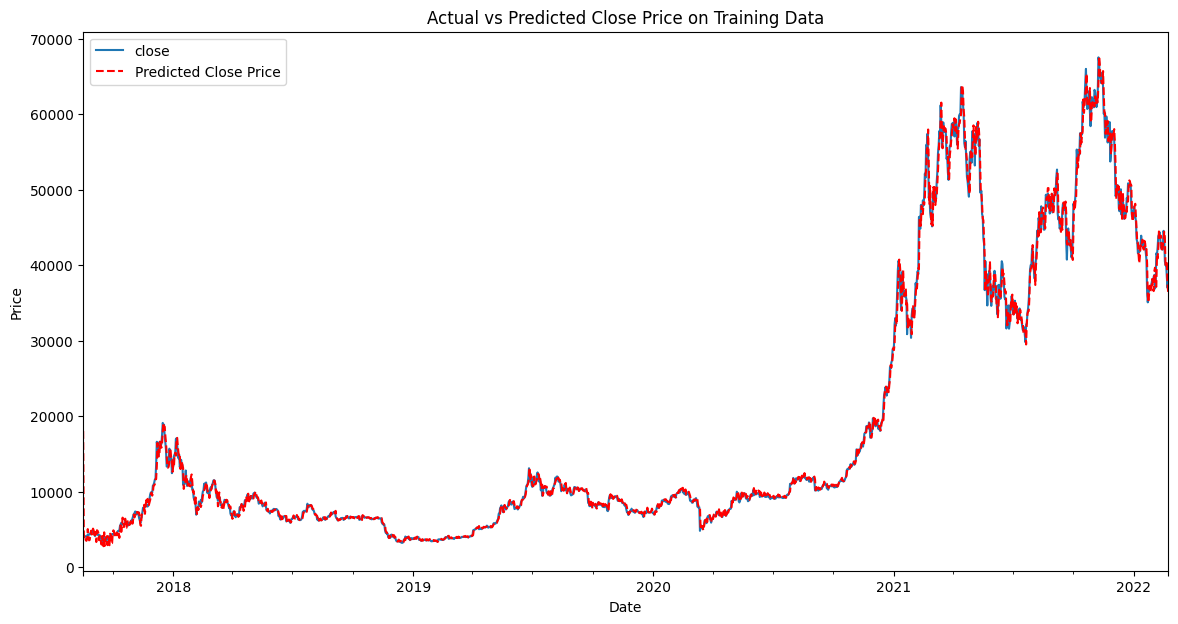

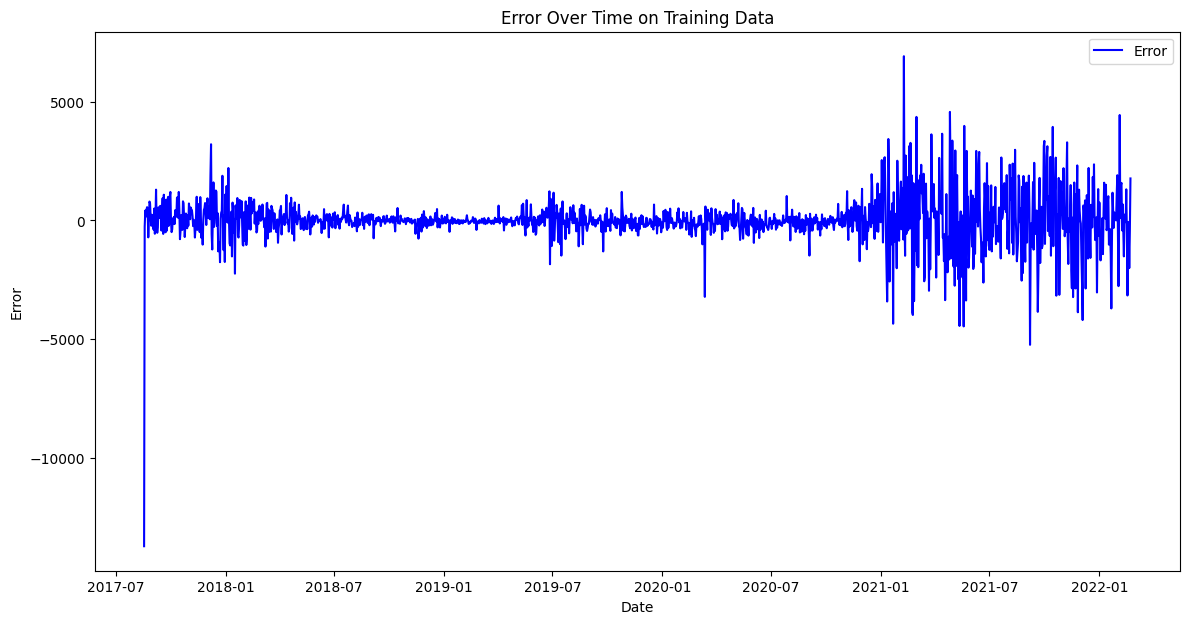

C:\Users\isaac\AppData\Local\Temp\ipykernel_10932\2763922360.py:31: UserWarning: This axis already has a converter set and is updating to a potentially incompatible converter
  plt.plot(validate.index, validate_predictions, label='Predicted Close Price', color='red', linestyle='--')


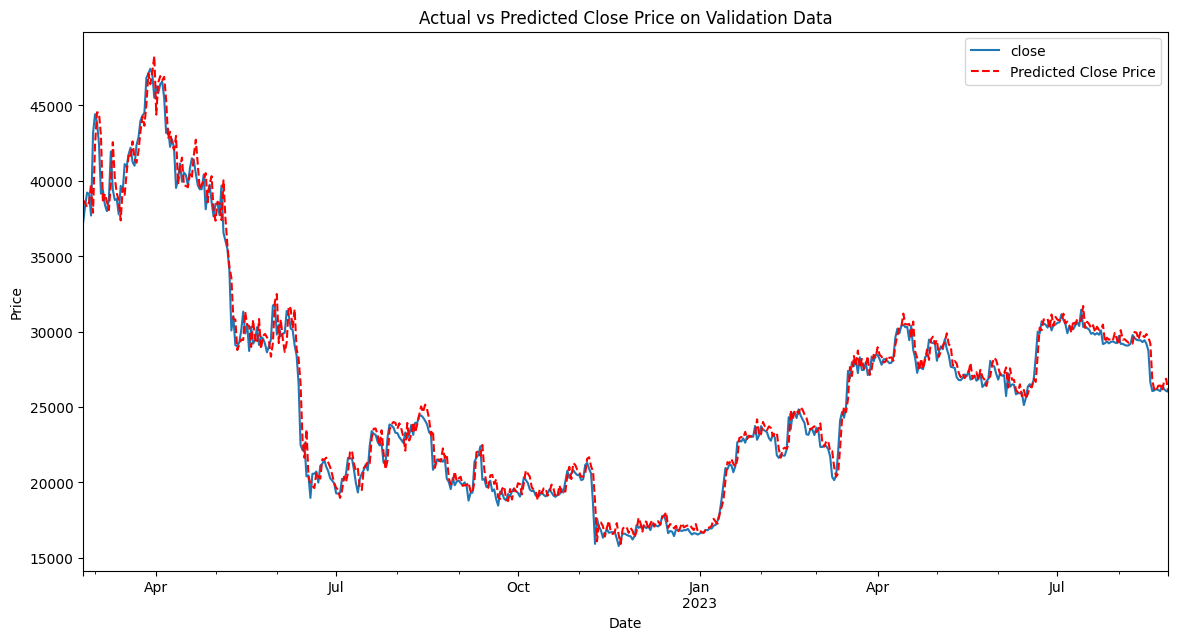

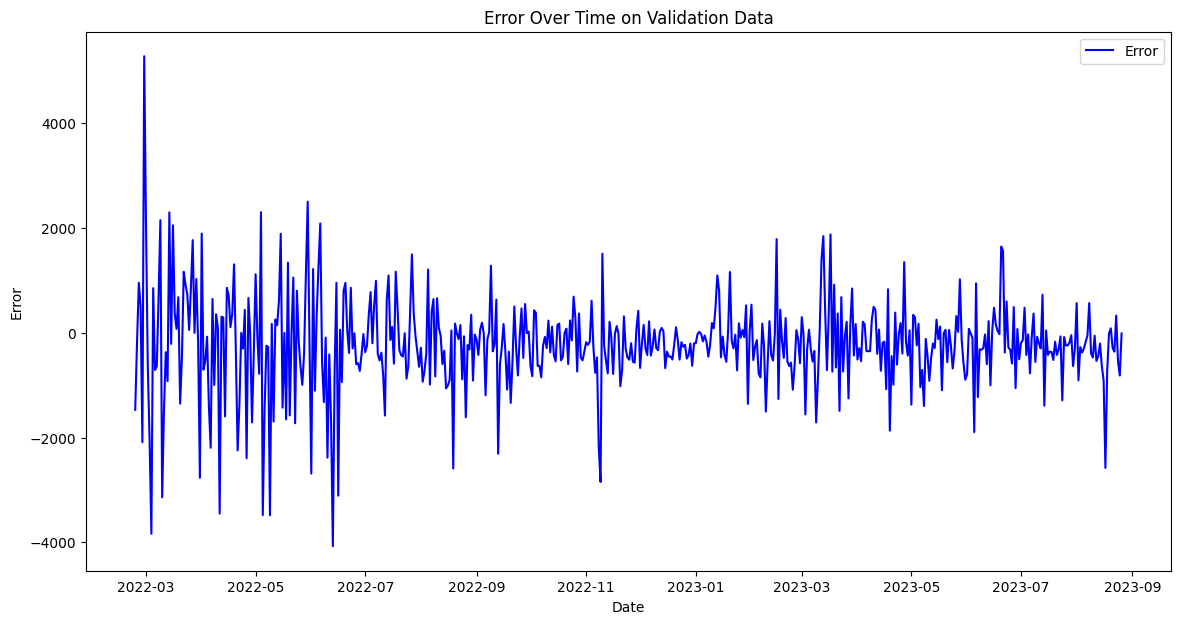

C:\Users\isaac\AppData\Local\Temp\ipykernel_10932\2763922360.py:55: UserWarning: This axis already has a converter set and is updating to a potentially incompatible converter
  plt.plot(test.index, test_predictions, label='Predicted Close Price', color='red', linestyle='--')


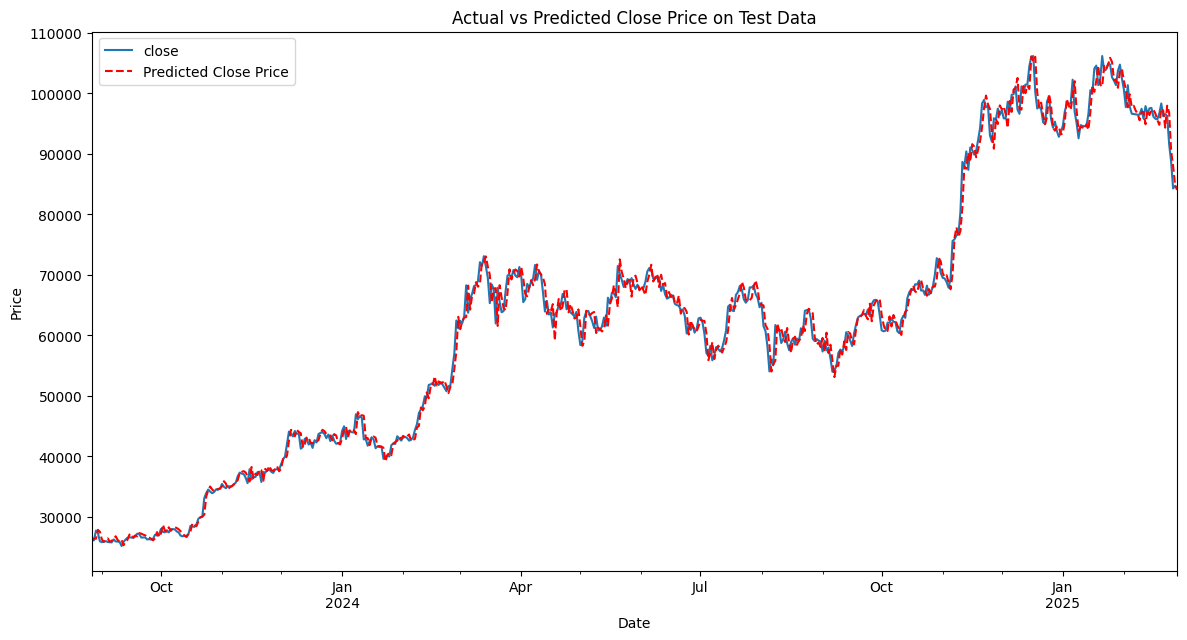

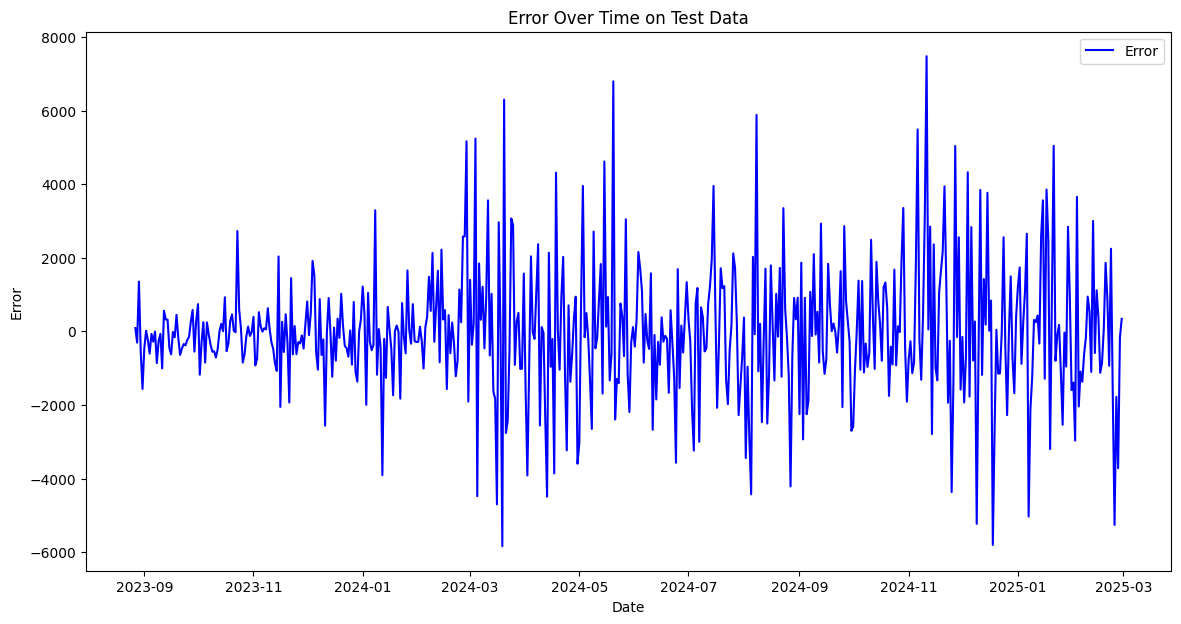

In [10]:
# Predict on the training data
train_predictions = model.predict(train_x_imputed)

# Plot the actual vs predicted prices
plt.figure(figsize=(14, 7))
train_y = pd.to_numeric(train_y)
train_y.plot(figsize=(14, 7), title='Train Y - Actual Close Prices')
plt.plot(train.index, train_predictions, label='Predicted Close Price', color='red', linestyle='--')
plt.xlabel('Date')
plt.ylabel('Price')
plt.title('Actual vs Predicted Close Price on Training Data')
plt.legend()
plt.show()

# Plot the error over time for training data
train_error = train_y - train_predictions
plt.figure(figsize=(14, 7))
plt.plot(train.index, train_error, label='Error', color='blue')
plt.xlabel('Date')
plt.ylabel('Error')
plt.title('Error Over Time on Training Data')
plt.legend()
plt.show()

# Predict on the validation data
validate_predictions = model.predict(validate_x_imputed)

plt.figure(figsize=(14, 7))
validate_y = pd.to_numeric(validate_y)
validate_y.plot(figsize=(14, 7))
plt.plot(validate.index, validate_predictions, label='Predicted Close Price', color='red', linestyle='--')
plt.xlabel('Date')
plt.ylabel('Price')
plt.title('Actual vs Predicted Close Price on Validation Data')
plt.legend()
plt.show()

# Plot the error over time for validation data
validate_error = validate_y - validate_predictions
plt.figure(figsize=(14, 7))
plt.plot(validate.index, validate_error, label='Error', color='blue')
plt.xlabel('Date')
plt.ylabel('Error')
plt.title('Error Over Time on Validation Data')
plt.legend()
plt.show()

# Predict on the test data
test_x_imputed = imputer.transform(test_x)
test_predictions = model.predict(test_x_imputed)

plt.figure(figsize=(14, 7))
test_y = pd.to_numeric(test_y)
test_y.plot(figsize=(14, 7))
plt.plot(test.index, test_predictions, label='Predicted Close Price', color='red', linestyle='--')
plt.xlabel('Date')
plt.ylabel('Price')
plt.title('Actual vs Predicted Close Price on Test Data')
plt.legend()
plt.show()

# Plot the error over time for validation data
test_error = test_y - test_predictions
plt.figure(figsize=(14, 7))
plt.plot(test.index, test_error, label='Error', color='blue')
plt.xlabel('Date')
plt.ylabel('Error')
plt.title('Error Over Time on Test Data')
plt.legend()
plt.show()


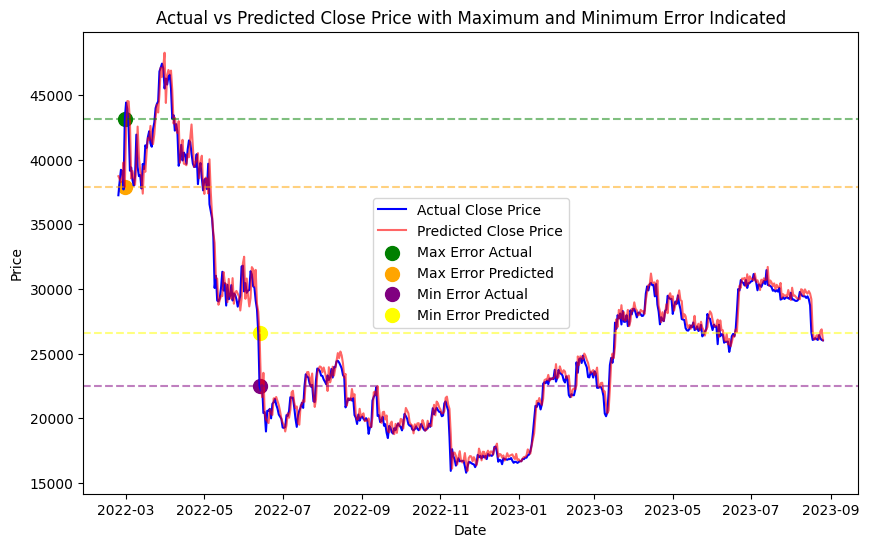

Max Error Date: 2022-02-28 00:00:00
Actual Close Price: 43160.0
Predicted Close Price: 37885.44233666061
Error: 5274.557663339387

Min Error Date: 2022-06-13 00:00:00
Actual Close Price: 22487.41
Predicted Close Price: 26561.12611780168
Error: -4073.7161178016795


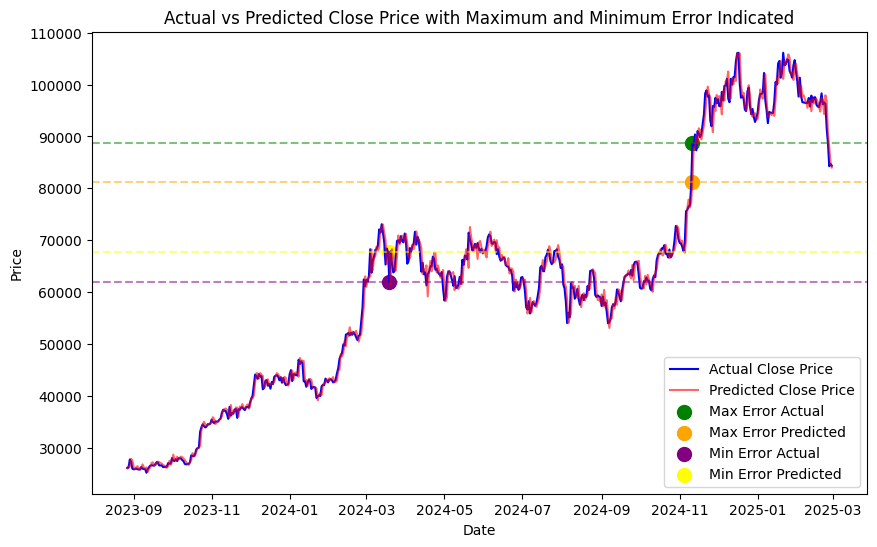

Max Error Date: 2024-11-11 00:00:00
Actual Close Price: 88647.99
Predicted Close Price: 81172.2422728643
Error: 7475.747727135706

Min Error Date: 2024-03-19 00:00:00
Actual Close Price: 61937.4
Predicted Close Price: 67776.10517527515
Error: -5838.70517527515


In [11]:
# Find the index of the maximum error
# Find the index of the maximum and minimum error
max_error_index = validate_error.idxmax()
min_error_index = validate_error.idxmin()

# Extract the corresponding values for maximum error
max_error_actual = validate_y.loc[max_error_index]
max_error_predicted = validate_predictions[validate_y.index.get_loc(max_error_index)]
max_error_value = validate_error[max_error_index]

# Extract the corresponding values for minimum error
min_error_actual = validate_y.loc[min_error_index]
min_error_predicted = validate_predictions[validate_y.index.get_loc(min_error_index)]
min_error_value = validate_error[min_error_index]

# Plot the scatter graph for maximum and minimum error
plt.figure(figsize=(10, 6))
plt.plot(validate_y.index, validate_y, label='Actual Close Price', color='blue')
plt.plot(validate_y.index, validate_predictions, label='Predicted Close Price', color='red', alpha=0.6)
plt.scatter(max_error_index, max_error_actual, color='green', s=100, label='Max Error Actual')
plt.scatter(max_error_index, max_error_predicted, color='orange', s=100, label='Max Error Predicted')
plt.scatter(min_error_index, min_error_actual, color='purple', s=100, label='Min Error Actual')
plt.scatter(min_error_index, min_error_predicted, color='yellow', s=100, label='Min Error Predicted')
plt.axhline(y=max_error_actual, color='green', linestyle='--', alpha=0.5)
plt.axhline(y=max_error_predicted, color='orange', linestyle='--', alpha=0.5)
plt.axhline(y=min_error_actual, color='purple', linestyle='--', alpha=0.5)
plt.axhline(y=min_error_predicted, color='yellow', linestyle='--', alpha=0.5)
plt.xlabel('Date')
plt.ylabel('Price')
plt.title('Actual vs Predicted Close Price with Maximum and Minimum Error Indicated')
plt.legend()
plt.show()

# Print the details of the maximum and minimum error
print(f'Max Error Date: {max_error_index}')
print(f'Actual Close Price: {max_error_actual}')
print(f'Predicted Close Price: {max_error_predicted}')
print(f'Error: {max_error_value}')

print(f'\nMin Error Date: {min_error_index}')
print(f'Actual Close Price: {min_error_actual}')
print(f'Predicted Close Price: {min_error_predicted}')
print(f'Error: {min_error_value}')

# Find the index of the maximum error
# Find the index of the maximum and minimum error
max_error_index = test_error.idxmax()
min_error_index = test_error.idxmin()

# Extract the corresponding values for maximum error
max_error_actual = test_y.loc[max_error_index]
max_error_predicted = test_predictions[test_y.index.get_loc(max_error_index)]
max_error_value = test_error[max_error_index]

# Extract the corresponding values for minimum error
min_error_actual = test_y.loc[min_error_index]
min_error_predicted = test_predictions[test_y.index.get_loc(min_error_index)]
min_error_value = test_error[min_error_index]

# Plot the scatter graph for maximum and minimum error
plt.figure(figsize=(10, 6))
plt.plot(test_y.index, test_y, label='Actual Close Price', color='blue')
plt.plot(test_y.index, test_predictions, label='Predicted Close Price', color='red', alpha=0.6)
plt.scatter(max_error_index, max_error_actual, color='green', s=100, label='Max Error Actual')
plt.scatter(max_error_index, max_error_predicted, color='orange', s=100, label='Max Error Predicted')
plt.scatter(min_error_index, min_error_actual, color='purple', s=100, label='Min Error Actual')
plt.scatter(min_error_index, min_error_predicted, color='yellow', s=100, label='Min Error Predicted')
plt.axhline(y=max_error_actual, color='green', linestyle='--', alpha=0.5)
plt.axhline(y=max_error_predicted, color='orange', linestyle='--', alpha=0.5)
plt.axhline(y=min_error_actual, color='purple', linestyle='--', alpha=0.5)
plt.axhline(y=min_error_predicted, color='yellow', linestyle='--', alpha=0.5)
plt.xlabel('Date')
plt.ylabel('Price')
plt.title('Actual vs Predicted Close Price with Maximum and Minimum Error Indicated')
plt.legend()
plt.show()

# Print the details of the maximum and minimum error
print(f'Max Error Date: {max_error_index}')
print(f'Actual Close Price: {max_error_actual}')
print(f'Predicted Close Price: {max_error_predicted}')
print(f'Error: {max_error_value}')

print(f'\nMin Error Date: {min_error_index}')
print(f'Actual Close Price: {min_error_actual}')
print(f'Predicted Close Price: {min_error_predicted}')
print(f'Error: {min_error_value}')

C:\Users\isaac\AppData\Local\Temp\ipykernel_10932\1335625644.py:8: UserWarning: This axis already has a converter set and is updating to a potentially incompatible converter
  plt.plot(train.index, train_predictions, label='Predicted Close Price', color='red', linestyle='--')


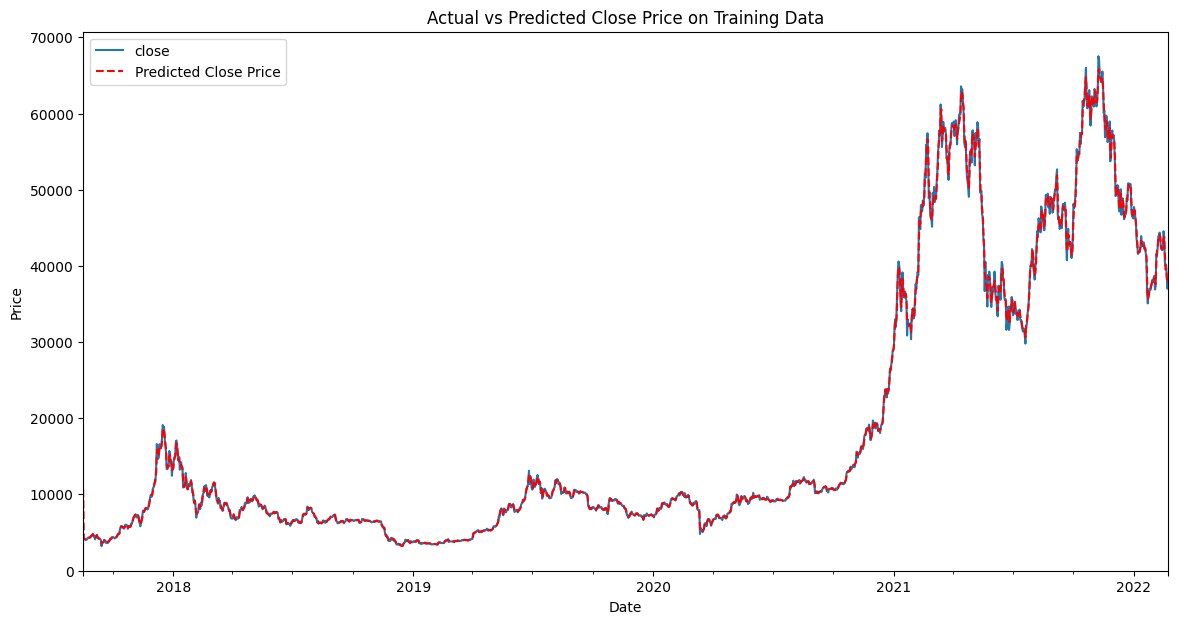

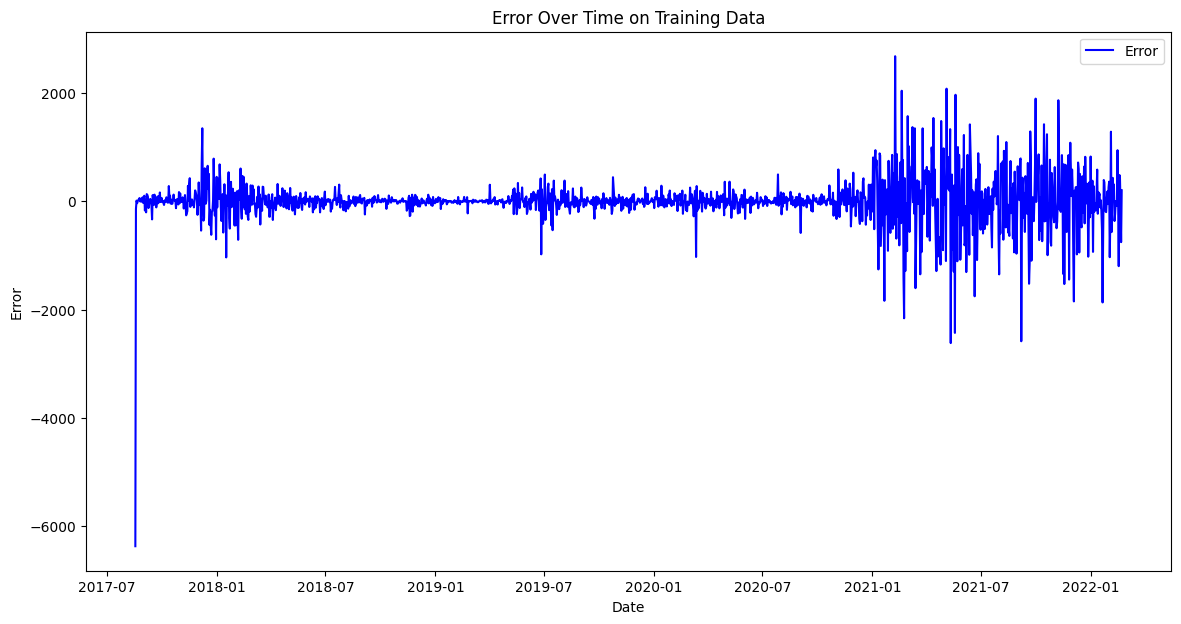

C:\Users\isaac\AppData\Local\Temp\ipykernel_10932\1335625644.py:31: UserWarning: This axis already has a converter set and is updating to a potentially incompatible converter
  plt.plot(validate.index, validate_predictions, label='Predicted Close Price', color='red', linestyle='--')


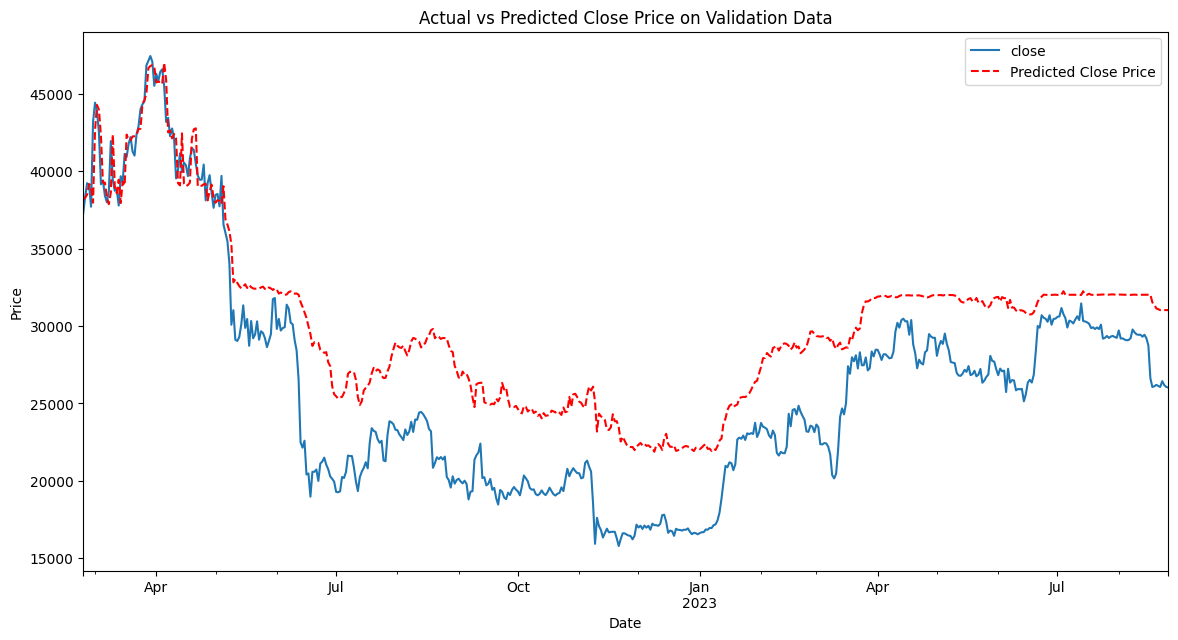

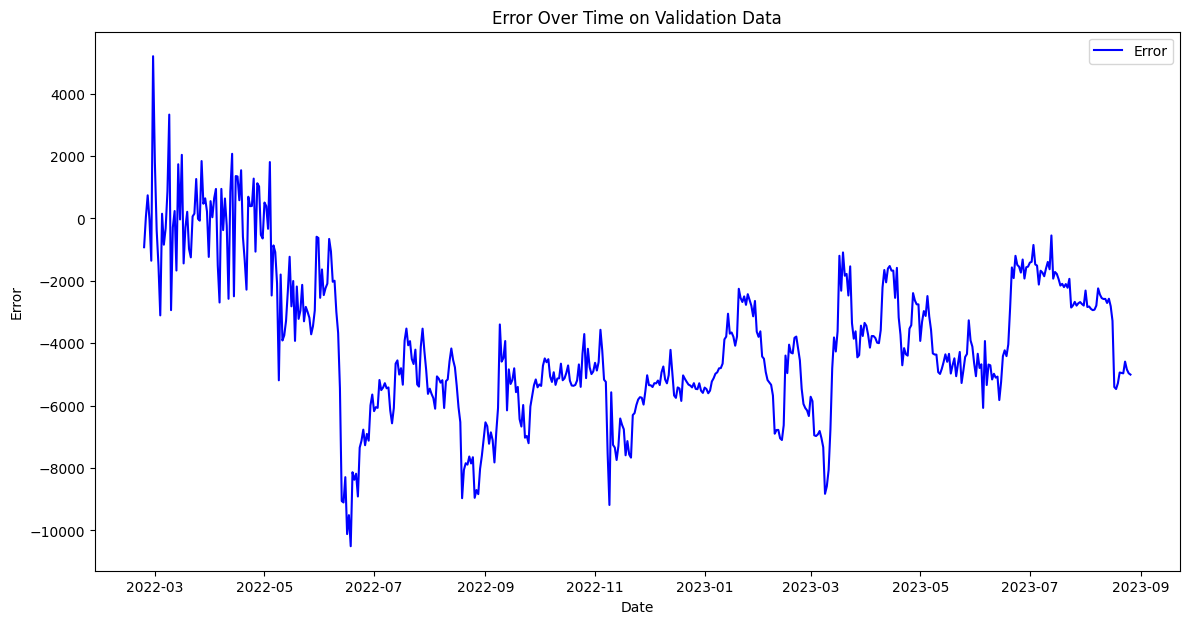

C:\Users\isaac\AppData\Local\Temp\ipykernel_10932\1335625644.py:55: UserWarning: This axis already has a converter set and is updating to a potentially incompatible converter
  plt.plot(test.index, test_predictions, label='Predicted Close Price', color='red', linestyle='--')


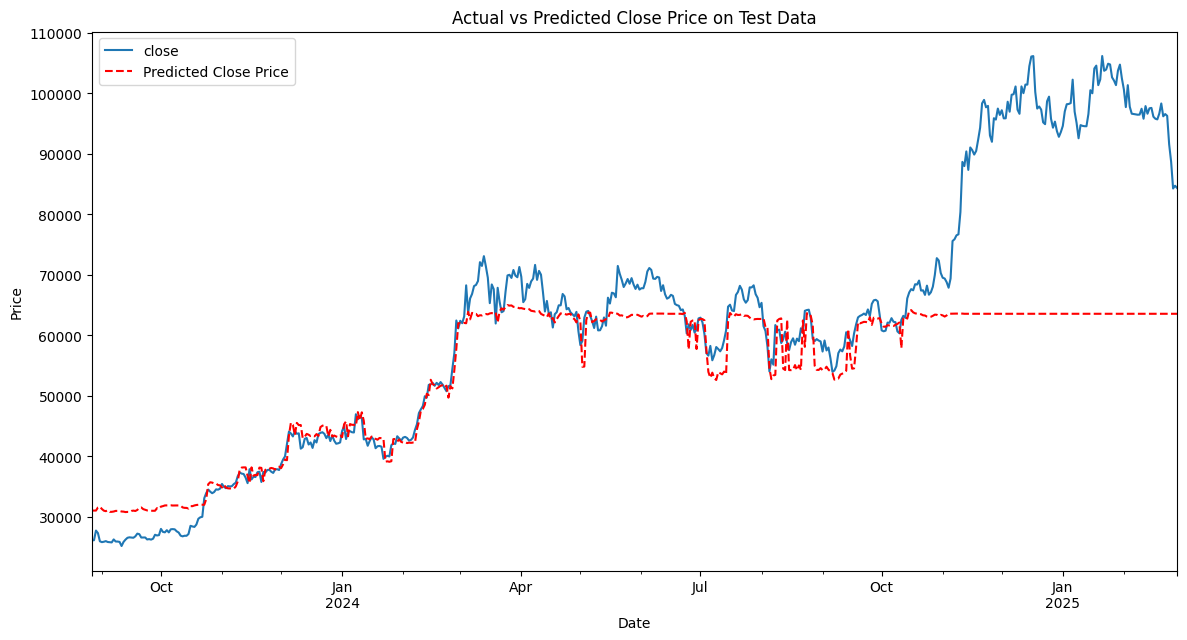

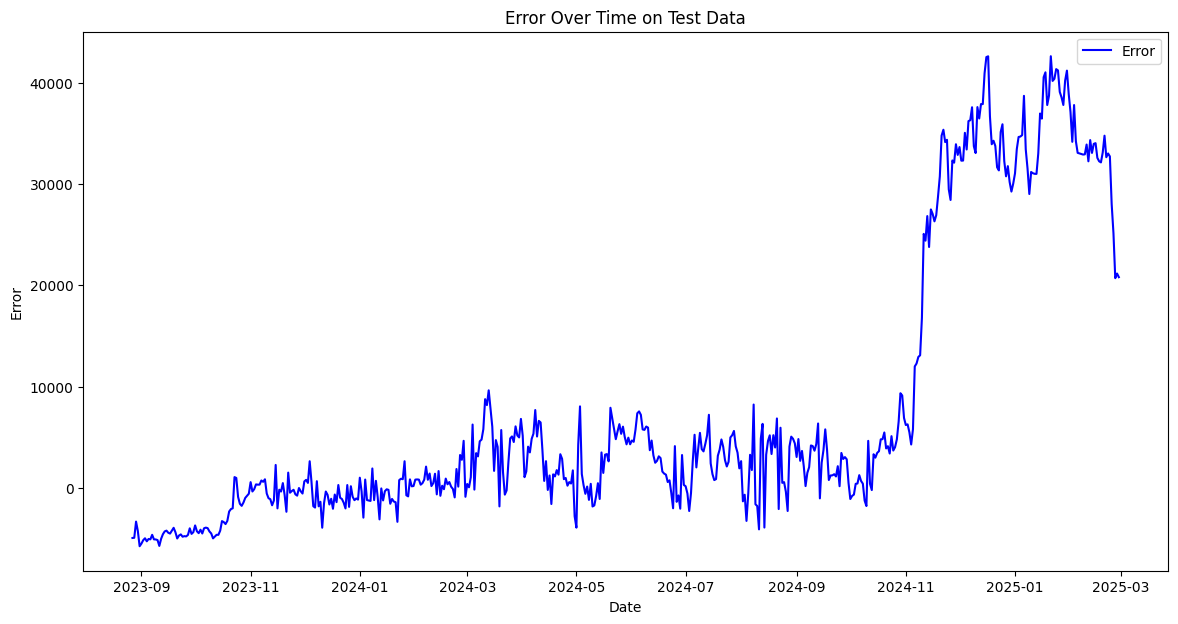

C:\Users\isaac\AppData\Local\Temp\ipykernel_10932\1335625644.py:78: UserWarning: This axis already has a converter set and is updating to a potentially incompatible converter
  plt.plot(train.index, train_predictions, label='Predicted Close Price', color='red', linestyle='--')


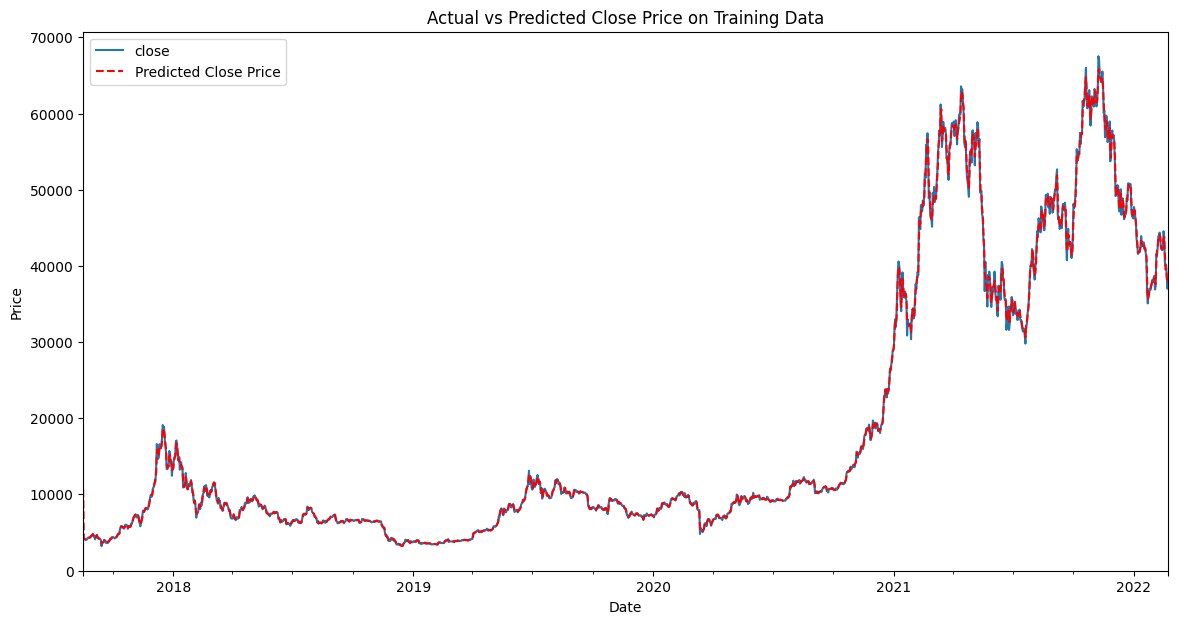

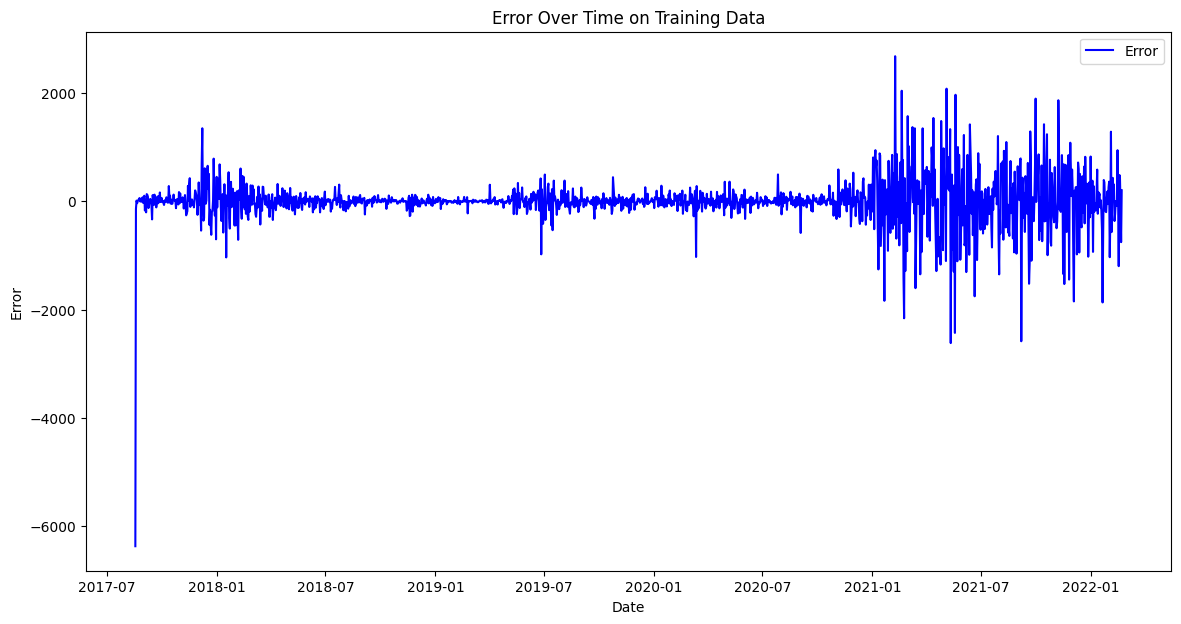

C:\Users\isaac\AppData\Local\Temp\ipykernel_10932\1335625644.py:102: UserWarning: This axis already has a converter set and is updating to a potentially incompatible converter
  plt.plot(validate.index, validate_predictions, label='Predicted Close Price', color='red', linestyle='--')


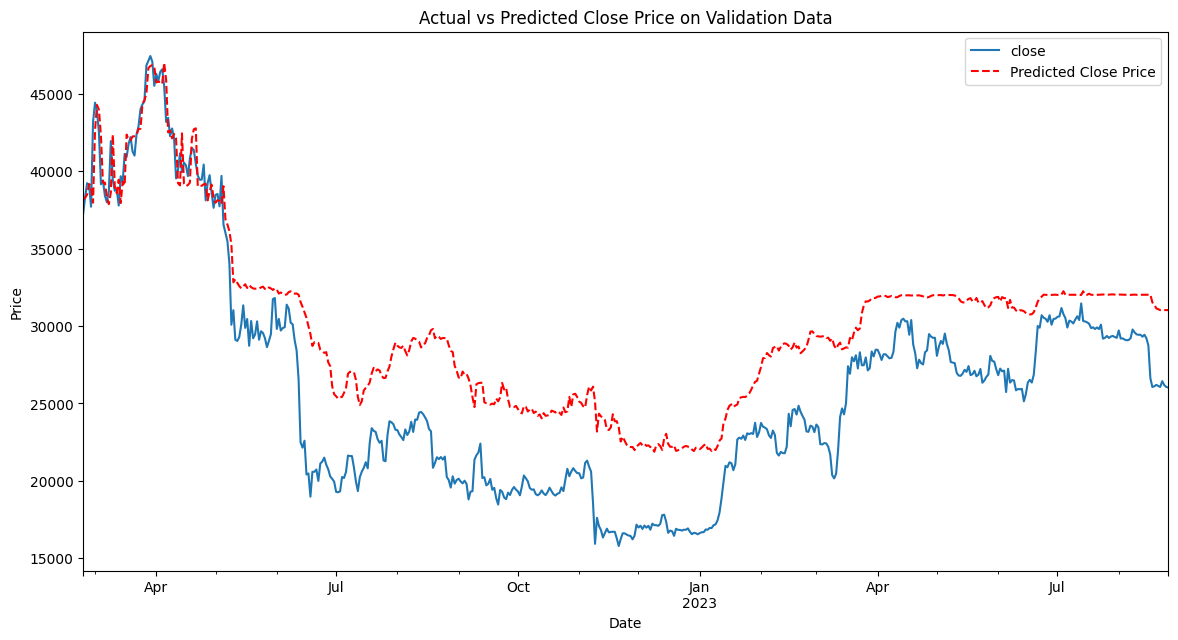

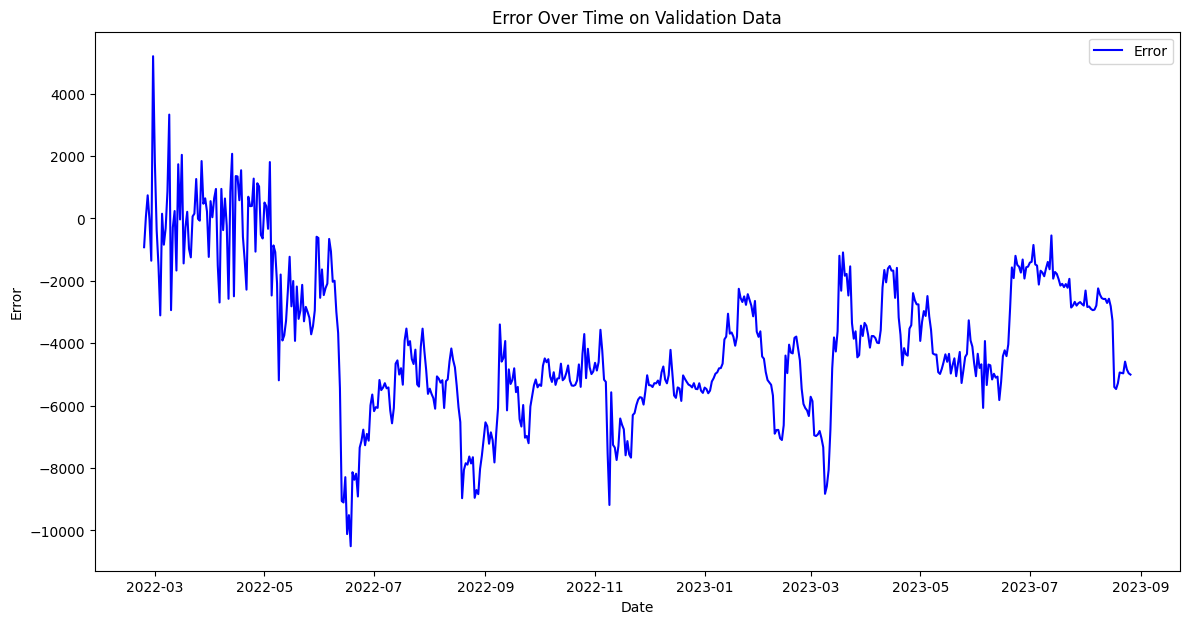

In [12]:
# Predict on the training data
train_predictions = rf_model.predict(train_x_imputed)

# Plot the actual vs predicted prices
plt.figure(figsize=(14, 7))
train_y = pd.to_numeric(train_y)
train_y.plot(figsize=(14, 7), title='Train Y - Actual Close Prices')
plt.plot(train.index, train_predictions, label='Predicted Close Price', color='red', linestyle='--')
plt.xlabel('Date')
plt.ylabel('Price')
plt.title('Actual vs Predicted Close Price on Training Data')
plt.legend()
plt.show()

# Plot the error over time for training data
train_error = train_y - train_predictions
plt.figure(figsize=(14, 7))
plt.plot(train.index, train_error, label='Error', color='blue')
plt.xlabel('Date')
plt.ylabel('Error')
plt.title('Error Over Time on Training Data')
plt.legend()
plt.show()

# Predict on the validation data
validate_predictions = rf_model.predict(validate_x_imputed)

plt.figure(figsize=(14, 7))
validate_y = pd.to_numeric(validate_y)
validate_y.plot(figsize=(14, 7))
plt.plot(validate.index, validate_predictions, label='Predicted Close Price', color='red', linestyle='--')
plt.xlabel('Date')
plt.ylabel('Price')
plt.title('Actual vs Predicted Close Price on Validation Data')
plt.legend()
plt.show()

# Plot the error over time for validation data
validate_error = validate_y - validate_predictions
plt.figure(figsize=(14, 7))
plt.plot(validate.index, validate_error, label='Error', color='blue')
plt.xlabel('Date')
plt.ylabel('Error')
plt.title('Error Over Time on Validation Data')
plt.legend()
plt.show()

# Predict on the test data
test_x_imputed = imputer.transform(test_x)
test_predictions = rf_model.predict(test_x_imputed)

plt.figure(figsize=(14, 7))
test_y = pd.to_numeric(test_y)
test_y.plot(figsize=(14, 7))
plt.plot(test.index, test_predictions, label='Predicted Close Price', color='red', linestyle='--')
plt.xlabel('Date')
plt.ylabel('Price')
plt.title('Actual vs Predicted Close Price on Test Data')
plt.legend()
plt.show()

# Plot the error over time for validation data
test_error = test_y - test_predictions
plt.figure(figsize=(14, 7))
plt.plot(test.index, test_error, label='Error', color='blue')
plt.xlabel('Date')
plt.ylabel('Error')
plt.title('Error Over Time on Test Data')
plt.legend()
plt.show()
# Predict on the training data
train_predictions = rf_model.predict(train_x_imputed)

# Plot the actual vs predicted prices
plt.figure(figsize=(14, 7))
train_y = pd.to_numeric(train_y)
train_y.plot(figsize=(14, 7), title='Train Y - Actual Close Prices')
plt.plot(train.index, train_predictions, label='Predicted Close Price', color='red', linestyle='--')
plt.xlabel('Date')
plt.ylabel('Price')
plt.title('Actual vs Predicted Close Price on Training Data')
plt.legend()
plt.show()

# Plot the error over time for training data
train_error = train_y - train_predictions
plt.figure(figsize=(14, 7))
plt.plot(train.index, train_error, label='Error', color='blue')
plt.xlabel('Date')
plt.ylabel('Error')
plt.title('Error Over Time on Training Data')
plt.legend()
plt.show()


# Predict on the validation data
test_predictions = rf_model.predict(test_x_imputed)

plt.figure(figsize=(14, 7))
validate_y = pd.to_numeric(validate_y)
validate_y.plot(figsize=(14, 7))
plt.plot(validate.index, validate_predictions, label='Predicted Close Price', color='red', linestyle='--')
plt.xlabel('Date')
plt.ylabel('Price')
plt.title('Actual vs Predicted Close Price on Validation Data')
plt.legend()
plt.show()

# Plot the error over time for validation data
validate_error = validate_y - validate_predictions
plt.figure(figsize=(14, 7))
plt.plot(validate.index, validate_error, label='Error', color='blue')
plt.xlabel('Date')
plt.ylabel('Error')
plt.title('Error Over Time on Validation Data')
plt.legend()
plt.show()

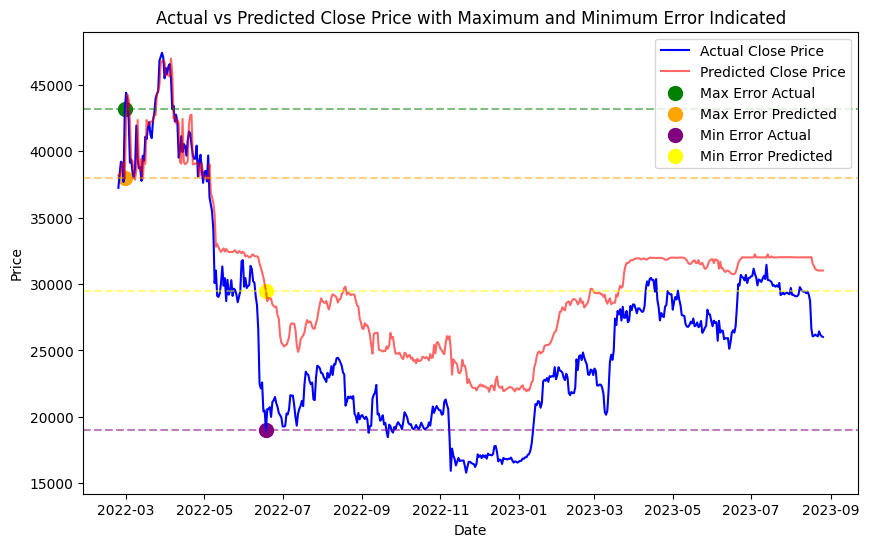

Max Error Date: 2022-02-28 00:00:00
Actual Close Price: 43160.0
Predicted Close Price: 37961.85760000001
Error: 5198.14239999999

Min Error Date: 2022-06-18 00:00:00
Actual Close Price: 18970.79
Predicted Close Price: 29476.692600000002
Error: -10505.902600000001


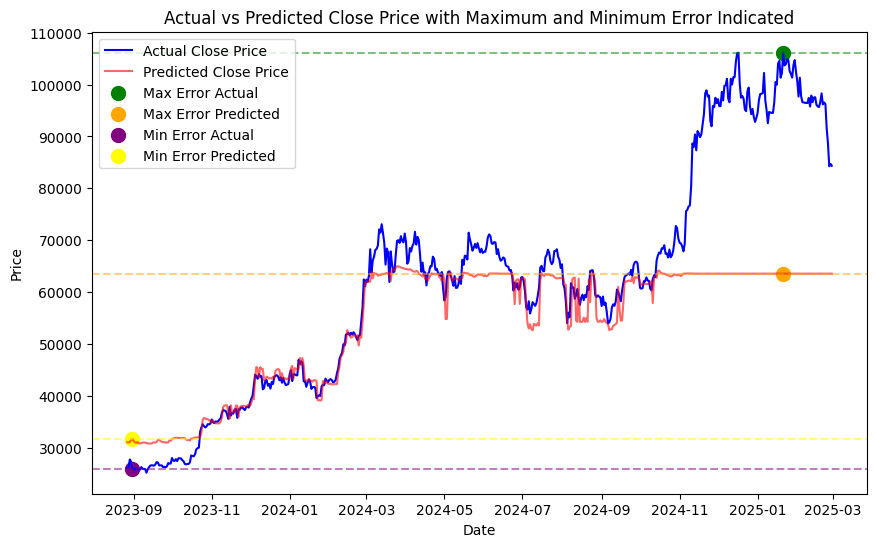

Max Error Date: 2025-01-21 00:00:00
Actual Close Price: 106143.82
Predicted Close Price: 63543.81440000001
Error: 42600.0056

Min Error Date: 2023-08-31 00:00:00
Actual Close Price: 25940.78
Predicted Close Price: 31674.554299999996
Error: -5733.774299999997


In [13]:
# Find the index of the maximum error
# Find the index of the maximum and minimum error
max_error_index = validate_error.idxmax()
min_error_index = validate_error.idxmin()

# Extract the corresponding values for maximum error
max_error_actual = validate_y.loc[max_error_index]
max_error_predicted = validate_predictions[validate_y.index.get_loc(max_error_index)]
max_error_value = validate_error[max_error_index]

# Extract the corresponding values for minimum error
min_error_actual = validate_y.loc[min_error_index]
min_error_predicted = validate_predictions[validate_y.index.get_loc(min_error_index)]
min_error_value = validate_error[min_error_index]

# Plot the scatter graph for maximum and minimum error
plt.figure(figsize=(10, 6))
plt.plot(validate_y.index, validate_y, label='Actual Close Price', color='blue')
plt.plot(validate_y.index, validate_predictions, label='Predicted Close Price', color='red', alpha=0.6)
plt.scatter(max_error_index, max_error_actual, color='green', s=100, label='Max Error Actual')
plt.scatter(max_error_index, max_error_predicted, color='orange', s=100, label='Max Error Predicted')
plt.scatter(min_error_index, min_error_actual, color='purple', s=100, label='Min Error Actual')
plt.scatter(min_error_index, min_error_predicted, color='yellow', s=100, label='Min Error Predicted')
plt.axhline(y=max_error_actual, color='green', linestyle='--', alpha=0.5)
plt.axhline(y=max_error_predicted, color='orange', linestyle='--', alpha=0.5)
plt.axhline(y=min_error_actual, color='purple', linestyle='--', alpha=0.5)
plt.axhline(y=min_error_predicted, color='yellow', linestyle='--', alpha=0.5)
plt.xlabel('Date')
plt.ylabel('Price')
plt.title('Actual vs Predicted Close Price with Maximum and Minimum Error Indicated')
plt.legend()
plt.show()

# Print the details of the maximum and minimum error
print(f'Max Error Date: {max_error_index}')
print(f'Actual Close Price: {max_error_actual}')
print(f'Predicted Close Price: {max_error_predicted}')
print(f'Error: {max_error_value}')

print(f'\nMin Error Date: {min_error_index}')
print(f'Actual Close Price: {min_error_actual}')
print(f'Predicted Close Price: {min_error_predicted}')
print(f'Error: {min_error_value}')

# Find the index of the maximum error
# Find the index of the maximum and minimum error
max_error_index = test_error.idxmax()
min_error_index = test_error.idxmin()

# Extract the corresponding values for maximum error
max_error_actual = test_y.loc[max_error_index]
max_error_predicted = test_predictions[test_y.index.get_loc(max_error_index)]
max_error_value = test_error[max_error_index]

# Extract the corresponding values for minimum error
min_error_actual = test_y.loc[min_error_index]
min_error_predicted = test_predictions[test_y.index.get_loc(min_error_index)]
min_error_value = test_error[min_error_index]

# Plot the scatter graph for maximum and minimum error
plt.figure(figsize=(10, 6))
plt.plot(test_y.index, test_y, label='Actual Close Price', color='blue')
plt.plot(test_y.index, test_predictions, label='Predicted Close Price', color='red', alpha=0.6)
plt.scatter(max_error_index, max_error_actual, color='green', s=100, label='Max Error Actual')
plt.scatter(max_error_index, max_error_predicted, color='orange', s=100, label='Max Error Predicted')
plt.scatter(min_error_index, min_error_actual, color='purple', s=100, label='Min Error Actual')
plt.scatter(min_error_index, min_error_predicted, color='yellow', s=100, label='Min Error Predicted')
plt.axhline(y=max_error_actual, color='green', linestyle='--', alpha=0.5)
plt.axhline(y=max_error_predicted, color='orange', linestyle='--', alpha=0.5)
plt.axhline(y=min_error_actual, color='purple', linestyle='--', alpha=0.5)
plt.axhline(y=min_error_predicted, color='yellow', linestyle='--', alpha=0.5)
plt.xlabel('Date')
plt.ylabel('Price')
plt.title('Actual vs Predicted Close Price with Maximum and Minimum Error Indicated')
plt.legend()
plt.show()

# Print the details of the maximum and minimum error
print(f'Max Error Date: {max_error_index}')
print(f'Actual Close Price: {max_error_actual}')
print(f'Predicted Close Price: {max_error_predicted}')
print(f'Error: {max_error_value}')

print(f'\nMin Error Date: {min_error_index}')
print(f'Actual Close Price: {min_error_actual}')
print(f'Predicted Close Price: {min_error_predicted}')
print(f'Error: {min_error_value}')

C:\Users\isaac\AppData\Local\Temp\ipykernel_10932\2882720607.py:8: UserWarning: This axis already has a converter set and is updating to a potentially incompatible converter
  plt.plot(train.index, train_predictions, label='Predicted Close Price', color='red', linestyle='--')


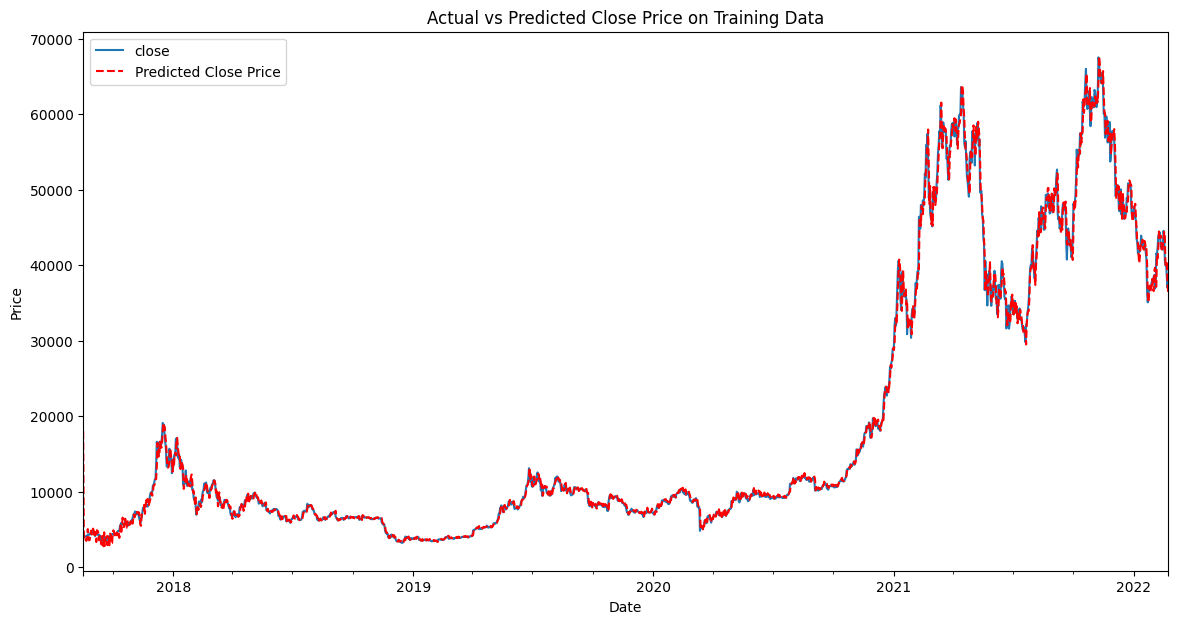

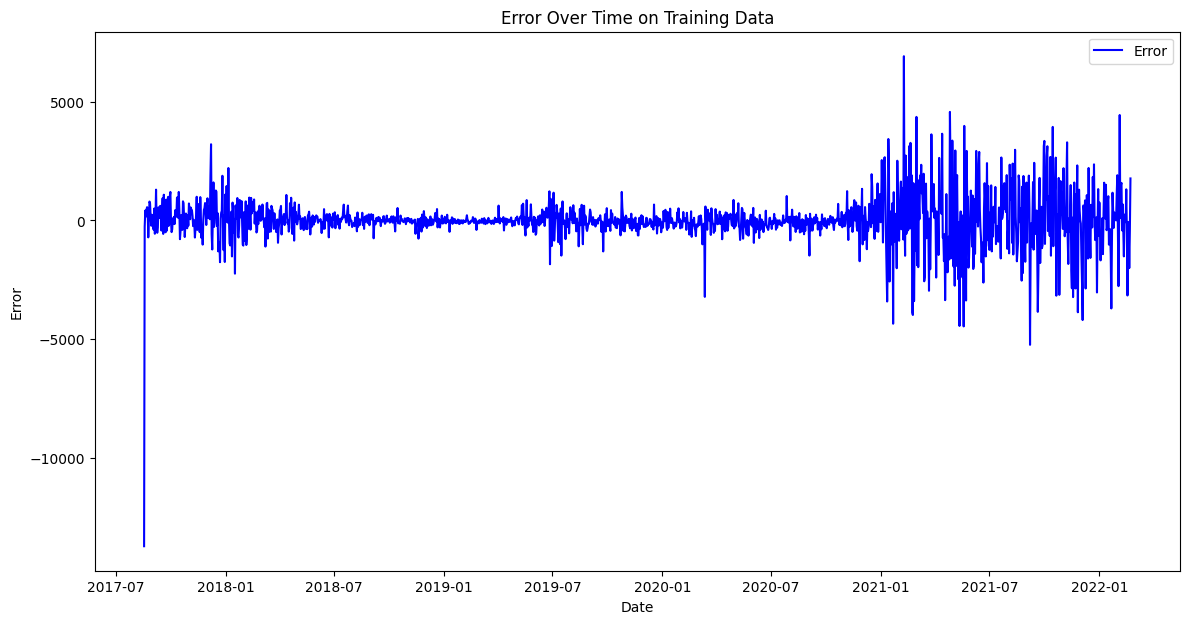

C:\Users\isaac\AppData\Local\Temp\ipykernel_10932\2882720607.py:31: UserWarning: This axis already has a converter set and is updating to a potentially incompatible converter
  plt.plot(validate.index, validate_predictions, label='Predicted Close Price', color='red', linestyle='--')


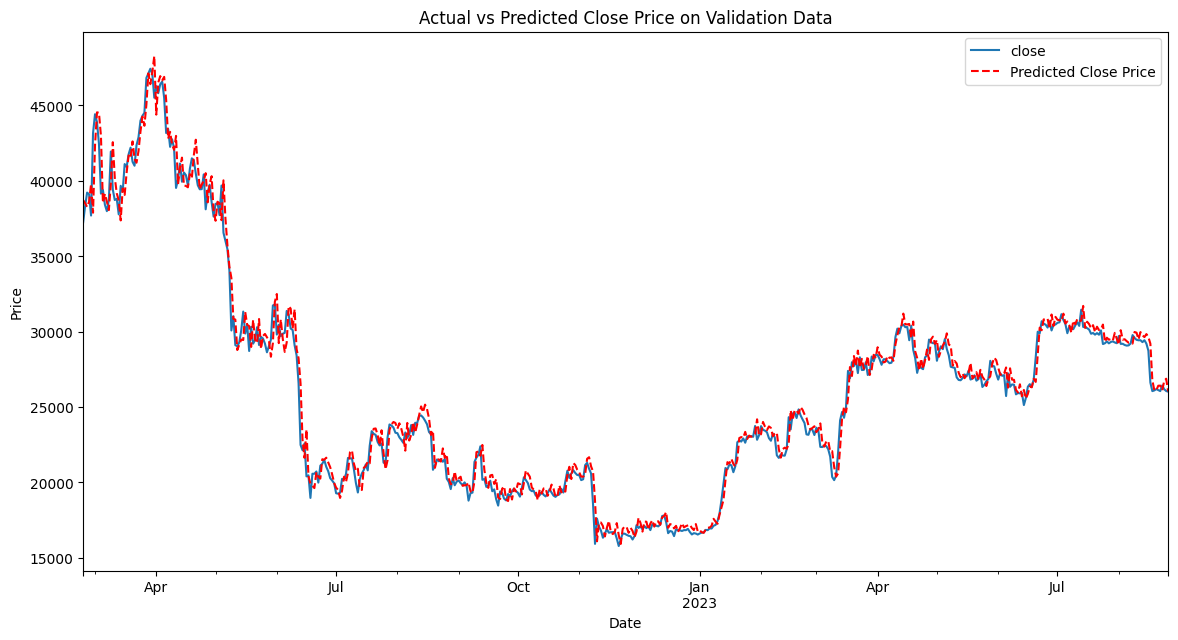

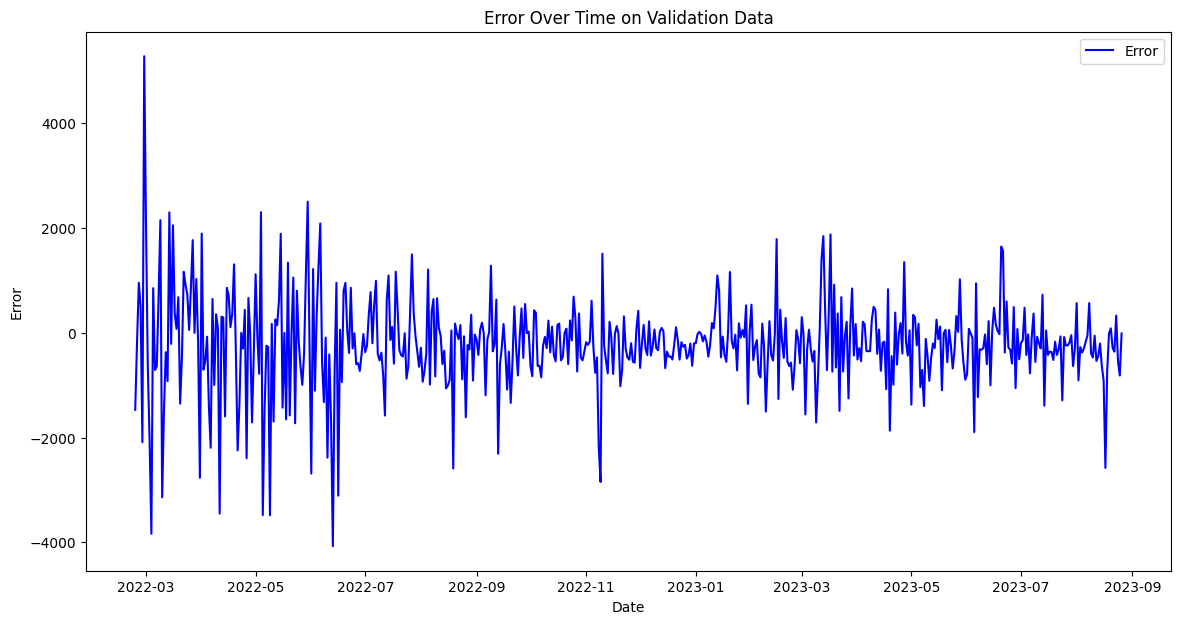

C:\Users\isaac\AppData\Local\Temp\ipykernel_10932\2882720607.py:55: UserWarning: This axis already has a converter set and is updating to a potentially incompatible converter
  plt.plot(test.index, test_predictions, label='Predicted Close Price', color='red', linestyle='--')


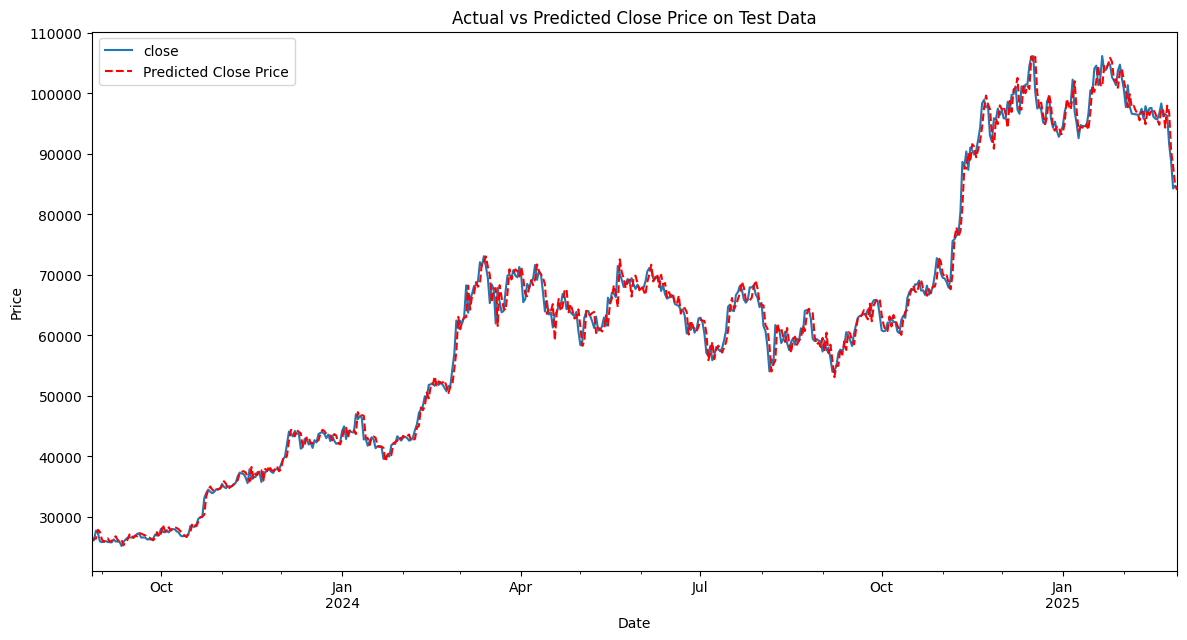

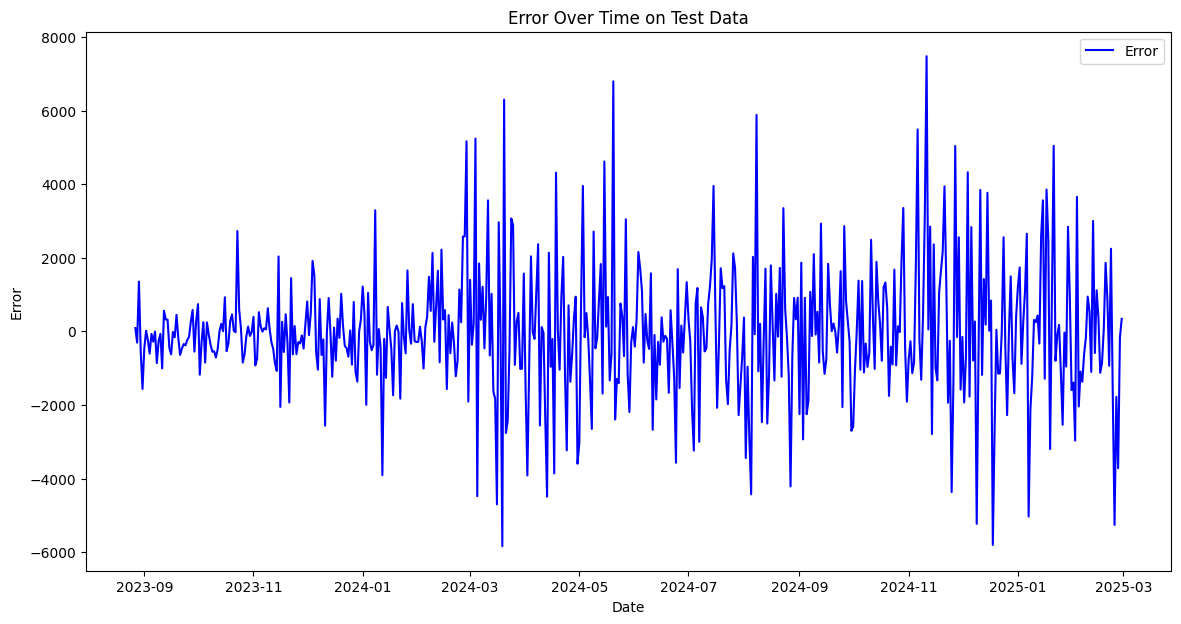

In [14]:
# Predict on the training data
train_predictions = ridge_model.predict(train_x_imputed)

# Plot the actual vs predicted prices
plt.figure(figsize=(14, 7))
train_y = pd.to_numeric(train_y)
train_y.plot(figsize=(14, 7), title='Train Y - Actual Close Prices')
plt.plot(train.index, train_predictions, label='Predicted Close Price', color='red', linestyle='--')
plt.xlabel('Date')
plt.ylabel('Price')
plt.title('Actual vs Predicted Close Price on Training Data')
plt.legend()
plt.show()

# Plot the error over time for training data
train_error = train_y - train_predictions
plt.figure(figsize=(14, 7))
plt.plot(train.index, train_error, label='Error', color='blue')
plt.xlabel('Date')
plt.ylabel('Error')
plt.title('Error Over Time on Training Data')
plt.legend()
plt.show()

# Predict on the validation data
validate_predictions = ridge_model.predict(validate_x_imputed)

plt.figure(figsize=(14, 7))
validate_y = pd.to_numeric(validate_y)
validate_y.plot(figsize=(14, 7))
plt.plot(validate.index, validate_predictions, label='Predicted Close Price', color='red', linestyle='--')
plt.xlabel('Date')
plt.ylabel('Price')
plt.title('Actual vs Predicted Close Price on Validation Data')
plt.legend()
plt.show()

# Plot the error over time for validation data
validate_error = validate_y - validate_predictions
plt.figure(figsize=(14, 7))
plt.plot(validate.index, validate_error, label='Error', color='blue')
plt.xlabel('Date')
plt.ylabel('Error')
plt.title('Error Over Time on Validation Data')
plt.legend()
plt.show()

# Predict on the test data
test_x_imputed = imputer.transform(test_x)
test_predictions = ridge_model.predict(test_x_imputed)

plt.figure(figsize=(14, 7))
test_y = pd.to_numeric(test_y)
test_y.plot(figsize=(14, 7))
plt.plot(test.index, test_predictions, label='Predicted Close Price', color='red', linestyle='--')
plt.xlabel('Date')
plt.ylabel('Price')
plt.title('Actual vs Predicted Close Price on Test Data')
plt.legend()
plt.show()

# Plot the error over time for validation data
test_error = test_y - test_predictions
plt.figure(figsize=(14, 7))
plt.plot(test.index, test_error, label='Error', color='blue')
plt.xlabel('Date')
plt.ylabel('Error')
plt.title('Error Over Time on Test Data')
plt.legend()
plt.show()


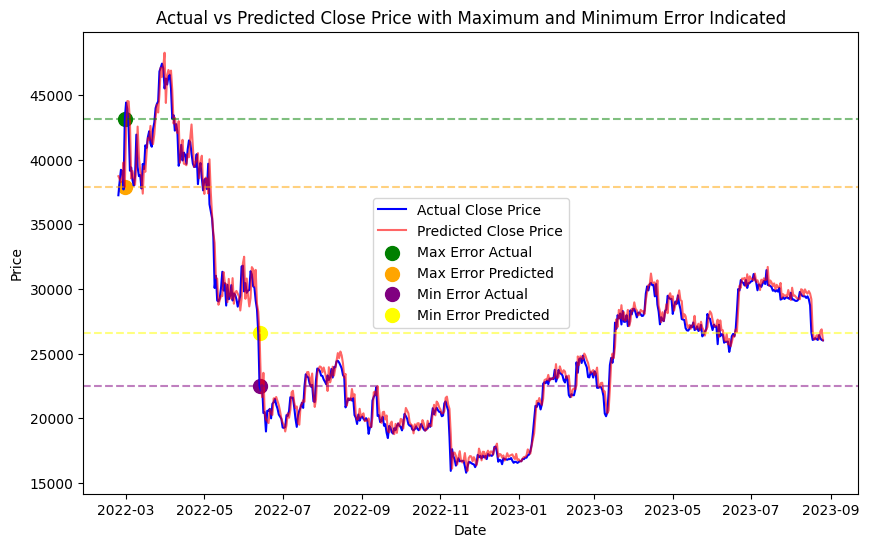

Max Error Date: 2022-02-28 00:00:00
Actual Close Price: 43160.0
Predicted Close Price: 37885.442337650515
Error: 5274.557662349485

Min Error Date: 2022-06-13 00:00:00
Actual Close Price: 22487.41
Predicted Close Price: 26561.12611800768
Error: -4073.71611800768


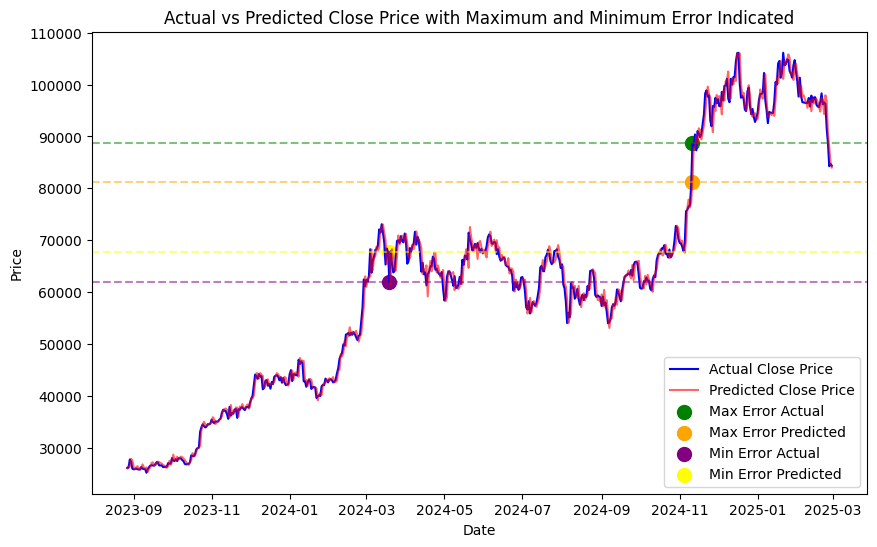

Max Error Date: 2024-11-11 00:00:00
Actual Close Price: 88647.99
Predicted Close Price: 81172.24226819353
Error: 7475.7477318064775

Min Error Date: 2024-03-19 00:00:00
Actual Close Price: 61937.4
Predicted Close Price: 67776.10517329816
Error: -5838.705173298156


In [15]:
# Find the index of the maximum error
# Find the index of the maximum and minimum error
max_error_index = validate_error.idxmax()
min_error_index = validate_error.idxmin()

# Extract the corresponding values for maximum error
max_error_actual = validate_y.loc[max_error_index]
max_error_predicted = validate_predictions[validate_y.index.get_loc(max_error_index)]
max_error_value = validate_error[max_error_index]

# Extract the corresponding values for minimum error
min_error_actual = validate_y.loc[min_error_index]
min_error_predicted = validate_predictions[validate_y.index.get_loc(min_error_index)]
min_error_value = validate_error[min_error_index]

# Plot the scatter graph for maximum and minimum error
plt.figure(figsize=(10, 6))
plt.plot(validate_y.index, validate_y, label='Actual Close Price', color='blue')
plt.plot(validate_y.index, validate_predictions, label='Predicted Close Price', color='red', alpha=0.6)
plt.scatter(max_error_index, max_error_actual, color='green', s=100, label='Max Error Actual')
plt.scatter(max_error_index, max_error_predicted, color='orange', s=100, label='Max Error Predicted')
plt.scatter(min_error_index, min_error_actual, color='purple', s=100, label='Min Error Actual')
plt.scatter(min_error_index, min_error_predicted, color='yellow', s=100, label='Min Error Predicted')
plt.axhline(y=max_error_actual, color='green', linestyle='--', alpha=0.5)
plt.axhline(y=max_error_predicted, color='orange', linestyle='--', alpha=0.5)
plt.axhline(y=min_error_actual, color='purple', linestyle='--', alpha=0.5)
plt.axhline(y=min_error_predicted, color='yellow', linestyle='--', alpha=0.5)
plt.xlabel('Date')
plt.ylabel('Price')
plt.title('Actual vs Predicted Close Price with Maximum and Minimum Error Indicated')
plt.legend()
plt.show()

# Print the details of the maximum and minimum error
print(f'Max Error Date: {max_error_index}')
print(f'Actual Close Price: {max_error_actual}')
print(f'Predicted Close Price: {max_error_predicted}')
print(f'Error: {max_error_value}')

print(f'\nMin Error Date: {min_error_index}')
print(f'Actual Close Price: {min_error_actual}')
print(f'Predicted Close Price: {min_error_predicted}')
print(f'Error: {min_error_value}')

# Find the index of the maximum error
# Find the index of the maximum and minimum error
max_error_index = test_error.idxmax()
min_error_index = test_error.idxmin()

# Extract the corresponding values for maximum error
max_error_actual = test_y.loc[max_error_index]
max_error_predicted = test_predictions[test_y.index.get_loc(max_error_index)]
max_error_value = test_error[max_error_index]

# Extract the corresponding values for minimum error
min_error_actual = test_y.loc[min_error_index]
min_error_predicted = test_predictions[test_y.index.get_loc(min_error_index)]
min_error_value = test_error[min_error_index]

# Plot the scatter graph for maximum and minimum error
plt.figure(figsize=(10, 6))
plt.plot(test_y.index, test_y, label='Actual Close Price', color='blue')
plt.plot(test_y.index, test_predictions, label='Predicted Close Price', color='red', alpha=0.6)
plt.scatter(max_error_index, max_error_actual, color='green', s=100, label='Max Error Actual')
plt.scatter(max_error_index, max_error_predicted, color='orange', s=100, label='Max Error Predicted')
plt.scatter(min_error_index, min_error_actual, color='purple', s=100, label='Min Error Actual')
plt.scatter(min_error_index, min_error_predicted, color='yellow', s=100, label='Min Error Predicted')
plt.axhline(y=max_error_actual, color='green', linestyle='--', alpha=0.5)
plt.axhline(y=max_error_predicted, color='orange', linestyle='--', alpha=0.5)
plt.axhline(y=min_error_actual, color='purple', linestyle='--', alpha=0.5)
plt.axhline(y=min_error_predicted, color='yellow', linestyle='--', alpha=0.5)
plt.xlabel('Date')
plt.ylabel('Price')
plt.title('Actual vs Predicted Close Price with Maximum and Minimum Error Indicated')
plt.legend()
plt.show()

# Print the details of the maximum and minimum error
print(f'Max Error Date: {max_error_index}')
print(f'Actual Close Price: {max_error_actual}')
print(f'Predicted Close Price: {max_error_predicted}')
print(f'Error: {max_error_value}')

print(f'\nMin Error Date: {min_error_index}')
print(f'Actual Close Price: {min_error_actual}')
print(f'Predicted Close Price: {min_error_predicted}')
print(f'Error: {min_error_value}')

C:\Users\isaac\AppData\Local\Temp\ipykernel_10932\2942938988.py:8: UserWarning: This axis already has a converter set and is updating to a potentially incompatible converter
  plt.plot(train.index, train_predictions, label='Predicted Close Price', color='red', linestyle='--')


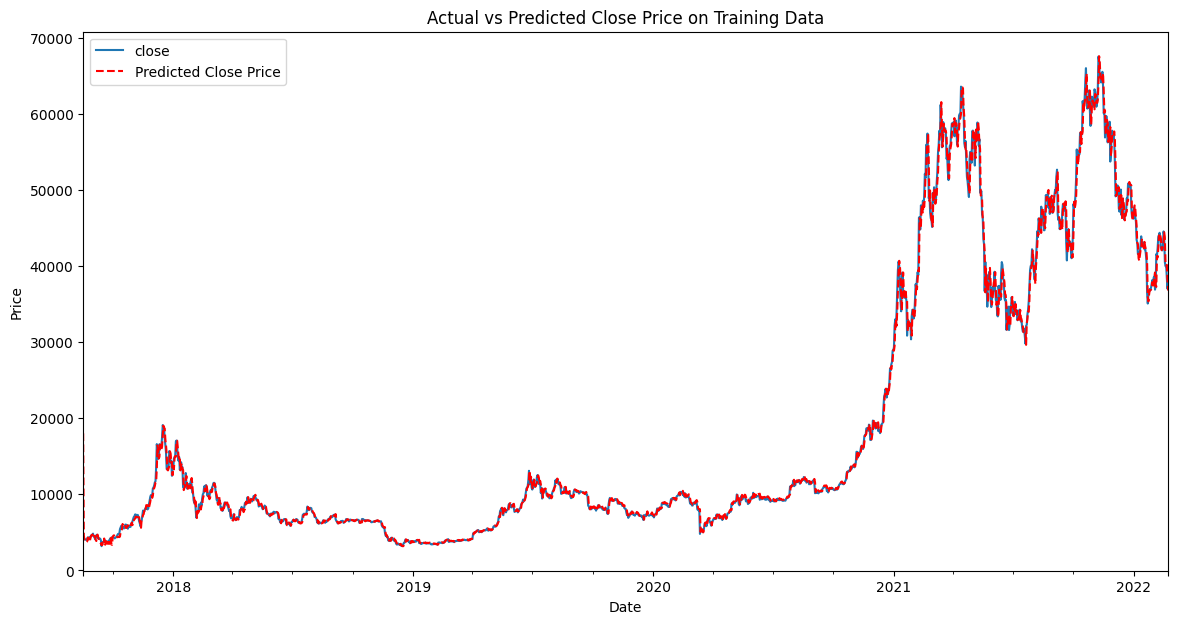

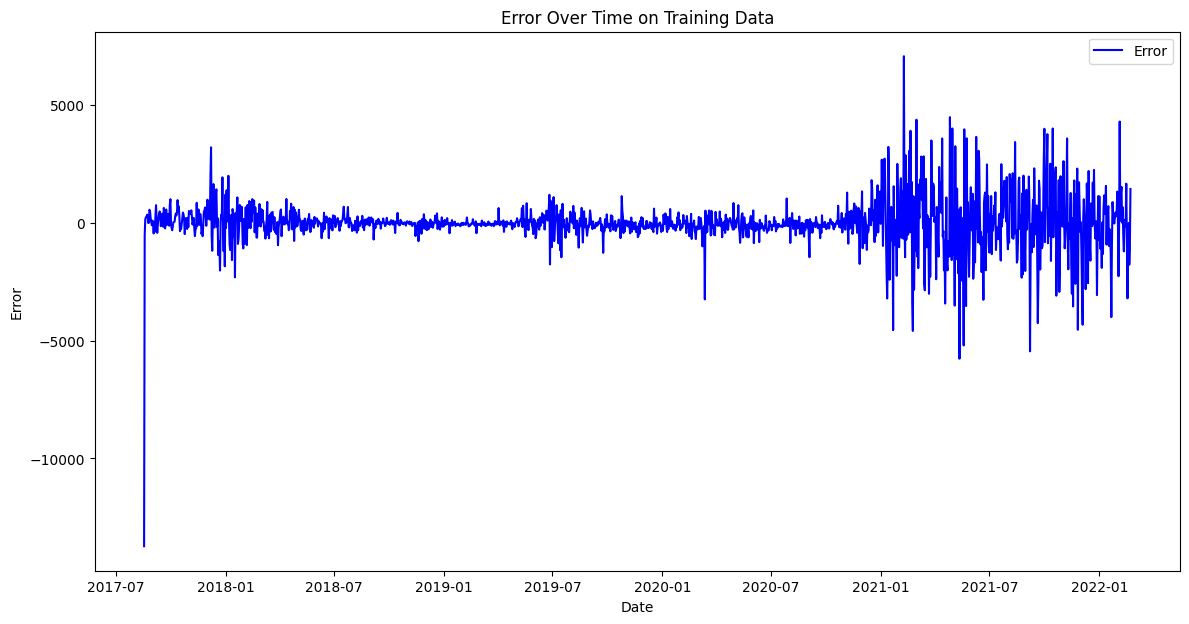

C:\Users\isaac\AppData\Local\Temp\ipykernel_10932\2942938988.py:31: UserWarning: This axis already has a converter set and is updating to a potentially incompatible converter
  plt.plot(validate.index, validate_predictions, label='Predicted Close Price', color='red', linestyle='--')


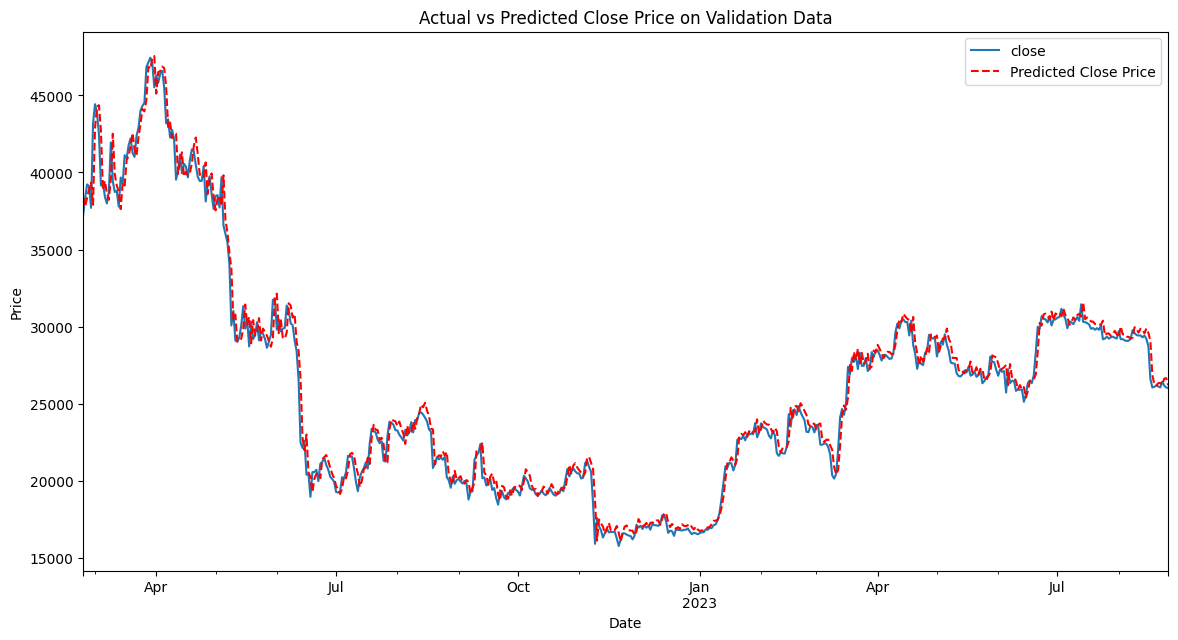

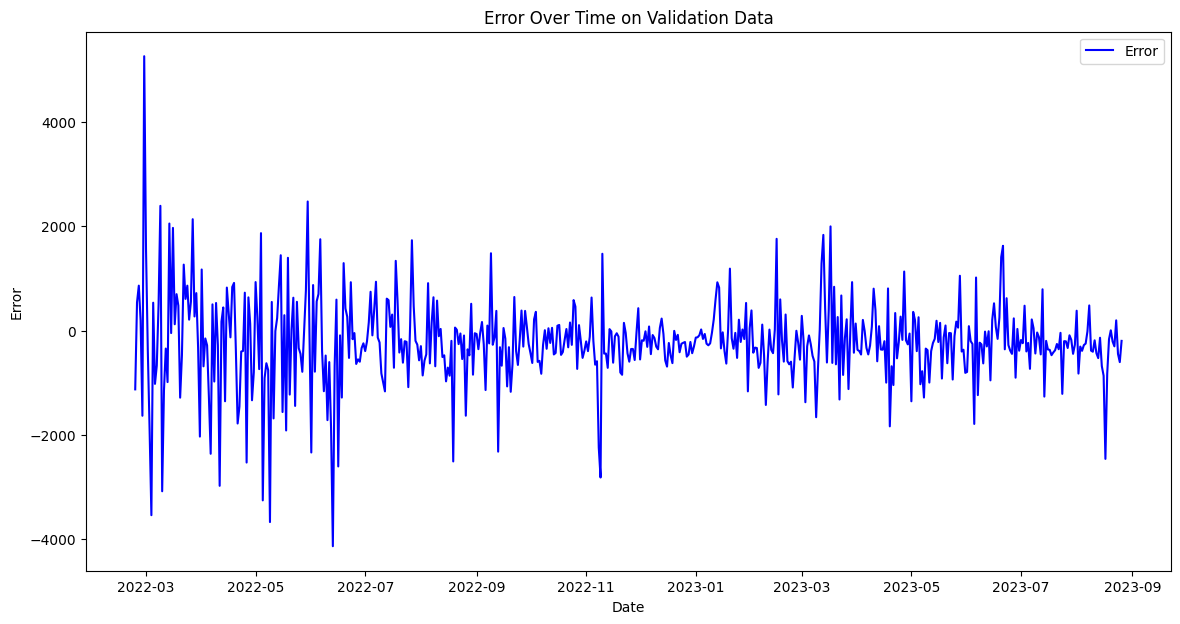

C:\Users\isaac\AppData\Local\Temp\ipykernel_10932\2942938988.py:55: UserWarning: This axis already has a converter set and is updating to a potentially incompatible converter
  plt.plot(test.index, test_predictions, label='Predicted Close Price', color='red', linestyle='--')


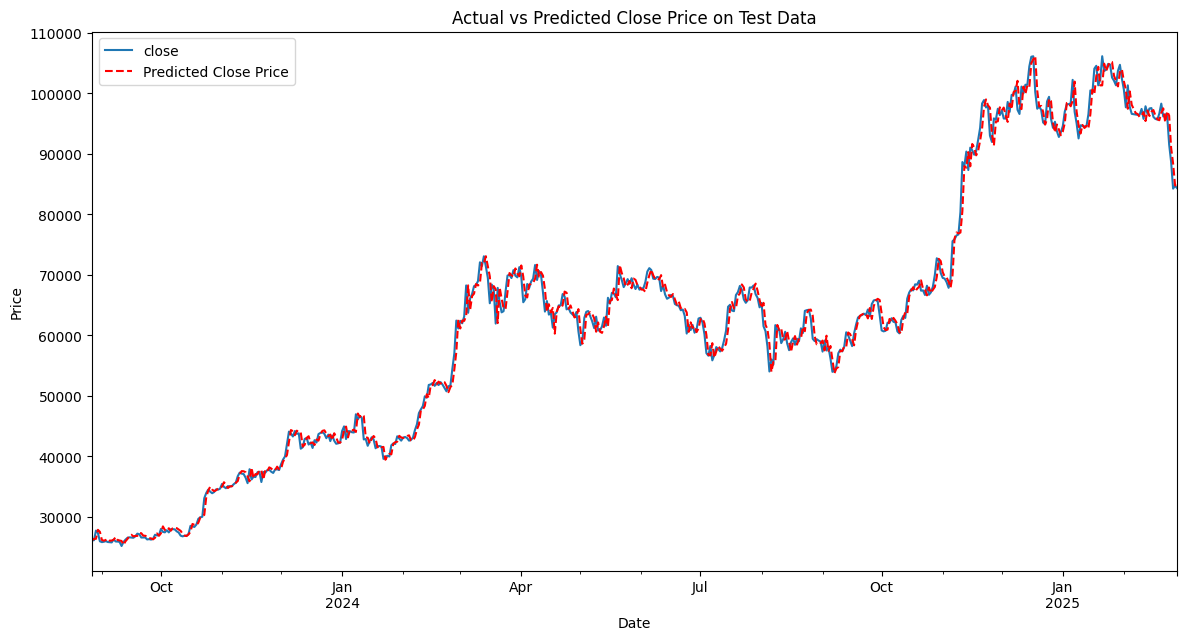

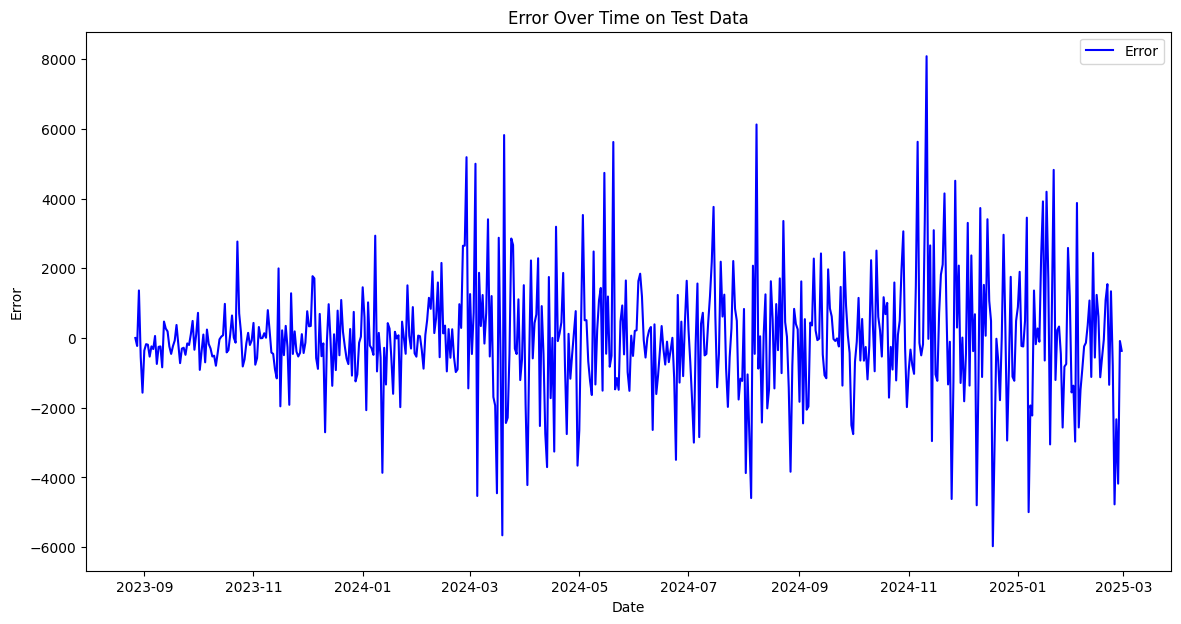

In [16]:
# Predict on the training data
train_predictions = lasso_pipeline.predict(train_x_imputed)

# Plot the actual vs predicted prices
plt.figure(figsize=(14, 7))
train_y = pd.to_numeric(train_y)
train_y.plot(figsize=(14, 7), title='Train Y - Actual Close Prices')
plt.plot(train.index, train_predictions, label='Predicted Close Price', color='red', linestyle='--')
plt.xlabel('Date')
plt.ylabel('Price')
plt.title('Actual vs Predicted Close Price on Training Data')
plt.legend()
plt.show()

# Plot the error over time for training data
train_error = train_y - train_predictions
plt.figure(figsize=(14, 7))
plt.plot(train.index, train_error, label='Error', color='blue')
plt.xlabel('Date')
plt.ylabel('Error')
plt.title('Error Over Time on Training Data')
plt.legend()
plt.show()

# Predict on the validation data
validate_predictions = lasso_pipeline.predict(validate_x_imputed)

plt.figure(figsize=(14, 7))
validate_y = pd.to_numeric(validate_y)
validate_y.plot(figsize=(14, 7))
plt.plot(validate.index, validate_predictions, label='Predicted Close Price', color='red', linestyle='--')
plt.xlabel('Date')
plt.ylabel('Price')
plt.title('Actual vs Predicted Close Price on Validation Data')
plt.legend()
plt.show()

# Plot the error over time for validation data
validate_error = validate_y - validate_predictions
plt.figure(figsize=(14, 7))
plt.plot(validate.index, validate_error, label='Error', color='blue')
plt.xlabel('Date')
plt.ylabel('Error')
plt.title('Error Over Time on Validation Data')
plt.legend()
plt.show()

# Predict on the test data
test_x_imputed = imputer.transform(test_x)
test_predictions = lasso_pipeline.predict(test_x_imputed)

plt.figure(figsize=(14, 7))
test_y = pd.to_numeric(test_y)
test_y.plot(figsize=(14, 7))
plt.plot(test.index, test_predictions, label='Predicted Close Price', color='red', linestyle='--')
plt.xlabel('Date')
plt.ylabel('Price')
plt.title('Actual vs Predicted Close Price on Test Data')
plt.legend()
plt.show()

# Plot the error over time for validation data
test_error = test_y - test_predictions
plt.figure(figsize=(14, 7))
plt.plot(test.index, test_error, label='Error', color='blue')
plt.xlabel('Date')
plt.ylabel('Error')
plt.title('Error Over Time on Test Data')
plt.legend()
plt.show()


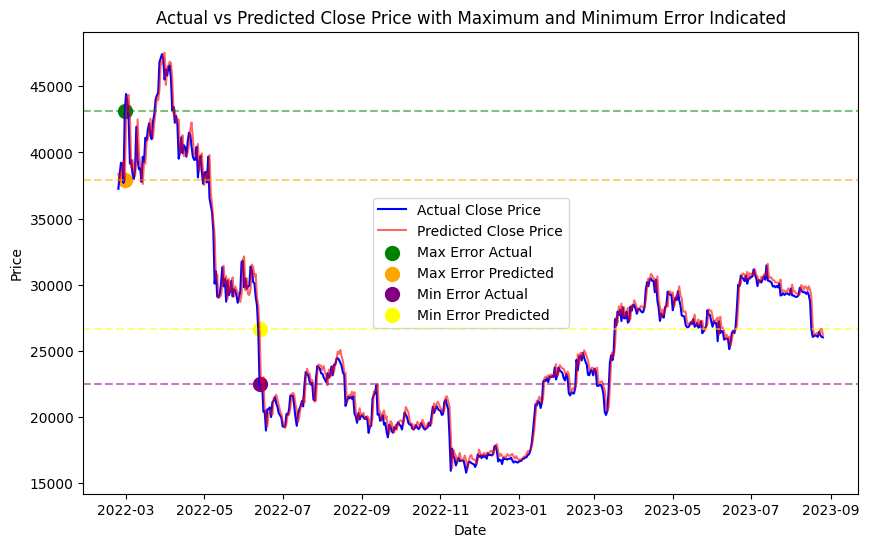

Max Error Date: 2022-02-28 00:00:00
Actual Close Price: 43160.0
Predicted Close Price: 37897.31654697257
Error: 5262.683453027428

Min Error Date: 2022-06-13 00:00:00
Actual Close Price: 22487.41
Predicted Close Price: 26621.186024674942
Error: -4133.776024674942


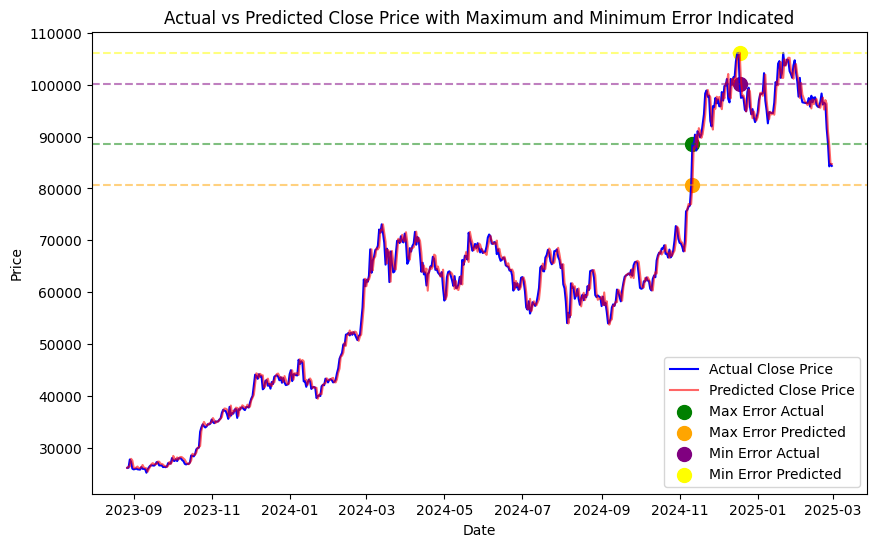

Max Error Date: 2024-11-11 00:00:00
Actual Close Price: 88647.99
Predicted Close Price: 80565.28474328882
Error: 8082.705256711182

Min Error Date: 2024-12-18 00:00:00
Actual Close Price: 100204.01
Predicted Close Price: 106175.21009151092
Error: -5971.200091510924


In [17]:
# Find the index of the maximum error
# Find the index of the maximum and minimum error
max_error_index = validate_error.idxmax()
min_error_index = validate_error.idxmin()

# Extract the corresponding values for maximum error
max_error_actual = validate_y.loc[max_error_index]
max_error_predicted = validate_predictions[validate_y.index.get_loc(max_error_index)]
max_error_value = validate_error[max_error_index]

# Extract the corresponding values for minimum error
min_error_actual = validate_y.loc[min_error_index]
min_error_predicted = validate_predictions[validate_y.index.get_loc(min_error_index)]
min_error_value = validate_error[min_error_index]

# Plot the scatter graph for maximum and minimum error
plt.figure(figsize=(10, 6))
plt.plot(validate_y.index, validate_y, label='Actual Close Price', color='blue')
plt.plot(validate_y.index, validate_predictions, label='Predicted Close Price', color='red', alpha=0.6)
plt.scatter(max_error_index, max_error_actual, color='green', s=100, label='Max Error Actual')
plt.scatter(max_error_index, max_error_predicted, color='orange', s=100, label='Max Error Predicted')
plt.scatter(min_error_index, min_error_actual, color='purple', s=100, label='Min Error Actual')
plt.scatter(min_error_index, min_error_predicted, color='yellow', s=100, label='Min Error Predicted')
plt.axhline(y=max_error_actual, color='green', linestyle='--', alpha=0.5)
plt.axhline(y=max_error_predicted, color='orange', linestyle='--', alpha=0.5)
plt.axhline(y=min_error_actual, color='purple', linestyle='--', alpha=0.5)
plt.axhline(y=min_error_predicted, color='yellow', linestyle='--', alpha=0.5)
plt.xlabel('Date')
plt.ylabel('Price')
plt.title('Actual vs Predicted Close Price with Maximum and Minimum Error Indicated')
plt.legend()
plt.show()

# Print the details of the maximum and minimum error
print(f'Max Error Date: {max_error_index}')
print(f'Actual Close Price: {max_error_actual}')
print(f'Predicted Close Price: {max_error_predicted}')
print(f'Error: {max_error_value}')

print(f'\nMin Error Date: {min_error_index}')
print(f'Actual Close Price: {min_error_actual}')
print(f'Predicted Close Price: {min_error_predicted}')
print(f'Error: {min_error_value}')

# Find the index of the maximum error
# Find the index of the maximum and minimum error
max_error_index = test_error.idxmax()
min_error_index = test_error.idxmin()

# Extract the corresponding values for maximum error
max_error_actual = test_y.loc[max_error_index]
max_error_predicted = test_predictions[test_y.index.get_loc(max_error_index)]
max_error_value = test_error[max_error_index]

# Extract the corresponding values for minimum error
min_error_actual = test_y.loc[min_error_index]
min_error_predicted = test_predictions[test_y.index.get_loc(min_error_index)]
min_error_value = test_error[min_error_index]

# Plot the scatter graph for maximum and minimum error
plt.figure(figsize=(10, 6))
plt.plot(test_y.index, test_y, label='Actual Close Price', color='blue')
plt.plot(test_y.index, test_predictions, label='Predicted Close Price', color='red', alpha=0.6)
plt.scatter(max_error_index, max_error_actual, color='green', s=100, label='Max Error Actual')
plt.scatter(max_error_index, max_error_predicted, color='orange', s=100, label='Max Error Predicted')
plt.scatter(min_error_index, min_error_actual, color='purple', s=100, label='Min Error Actual')
plt.scatter(min_error_index, min_error_predicted, color='yellow', s=100, label='Min Error Predicted')
plt.axhline(y=max_error_actual, color='green', linestyle='--', alpha=0.5)
plt.axhline(y=max_error_predicted, color='orange', linestyle='--', alpha=0.5)
plt.axhline(y=min_error_actual, color='purple', linestyle='--', alpha=0.5)
plt.axhline(y=min_error_predicted, color='yellow', linestyle='--', alpha=0.5)
plt.xlabel('Date')
plt.ylabel('Price')
plt.title('Actual vs Predicted Close Price with Maximum and Minimum Error Indicated')
plt.legend()
plt.show()

# Print the details of the maximum and minimum error
print(f'Max Error Date: {max_error_index}')
print(f'Actual Close Price: {max_error_actual}')
print(f'Predicted Close Price: {max_error_predicted}')
print(f'Error: {max_error_value}')

print(f'\nMin Error Date: {min_error_index}')
print(f'Actual Close Price: {min_error_actual}')
print(f'Predicted Close Price: {min_error_predicted}')
print(f'Error: {min_error_value}')

C:\Users\isaac\AppData\Local\Temp\ipykernel_10932\1186291716.py:8: UserWarning: This axis already has a converter set and is updating to a potentially incompatible converter
  plt.plot(train.index, train_predictions, label='Predicted Close Price', color='red', linestyle='--')


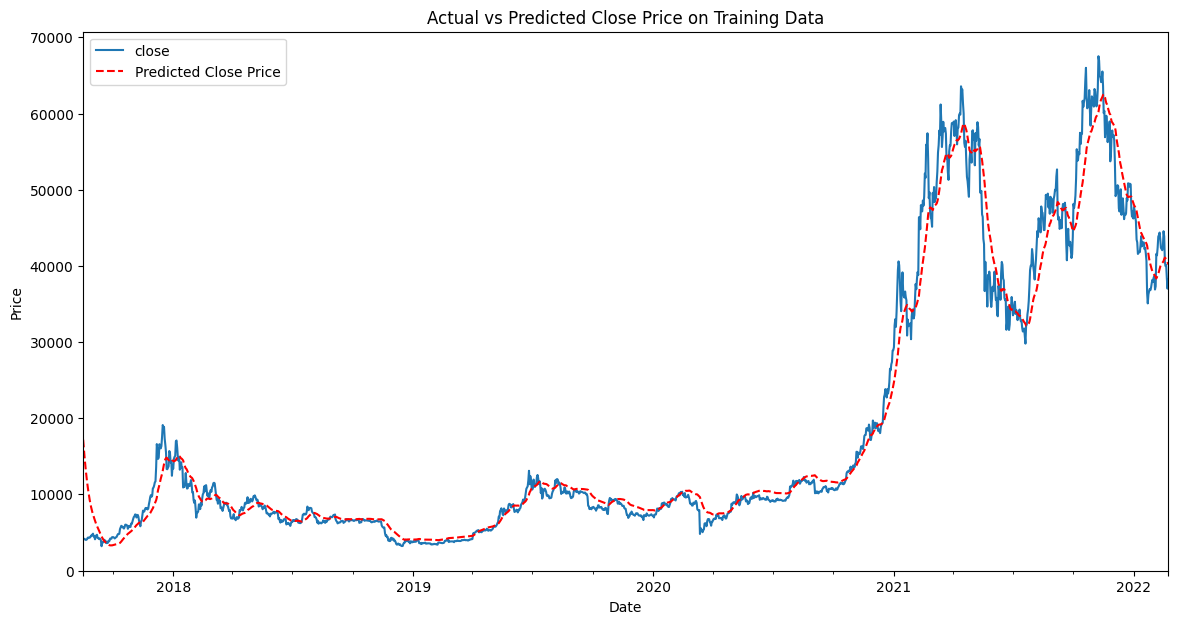

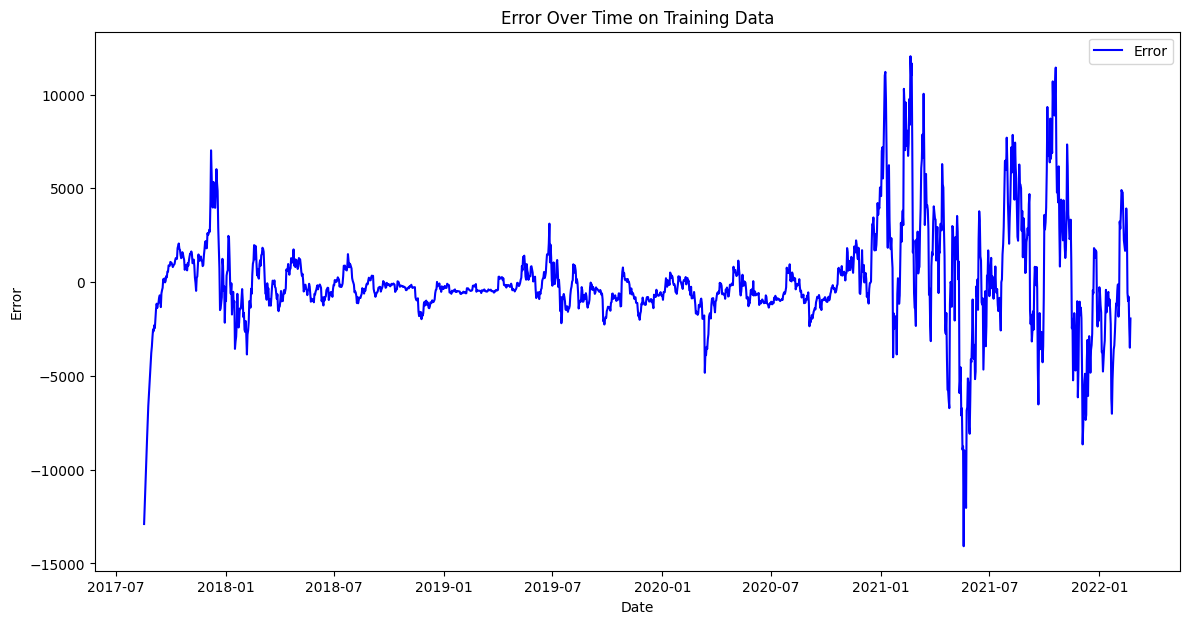

C:\Users\isaac\AppData\Local\Temp\ipykernel_10932\1186291716.py:31: UserWarning: This axis already has a converter set and is updating to a potentially incompatible converter
  plt.plot(validate.index, validate_predictions, label='Predicted Close Price', color='red', linestyle='--')


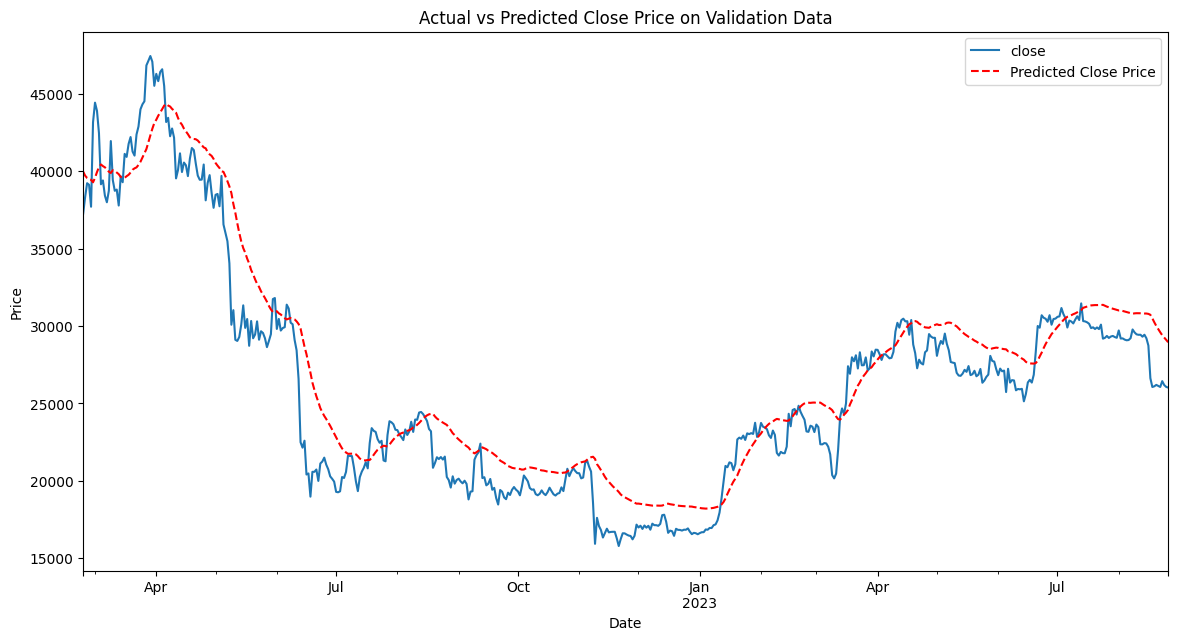

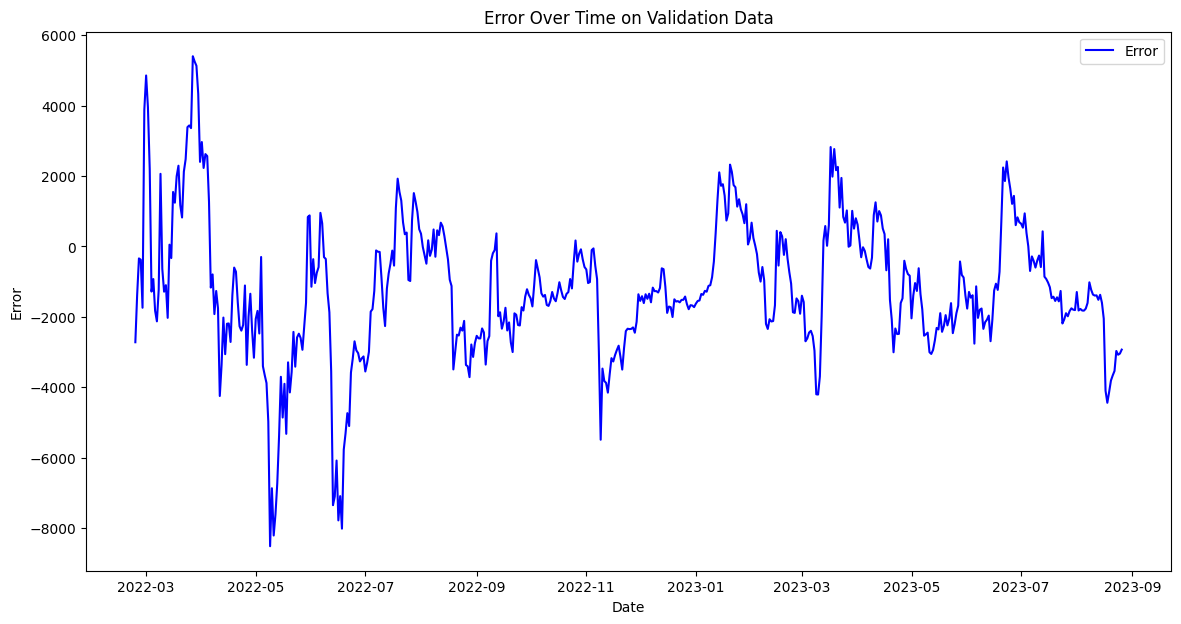

C:\Users\isaac\AppData\Local\Temp\ipykernel_10932\1186291716.py:55: UserWarning: This axis already has a converter set and is updating to a potentially incompatible converter
  plt.plot(test.index, test_predictions, label='Predicted Close Price', color='red', linestyle='--')


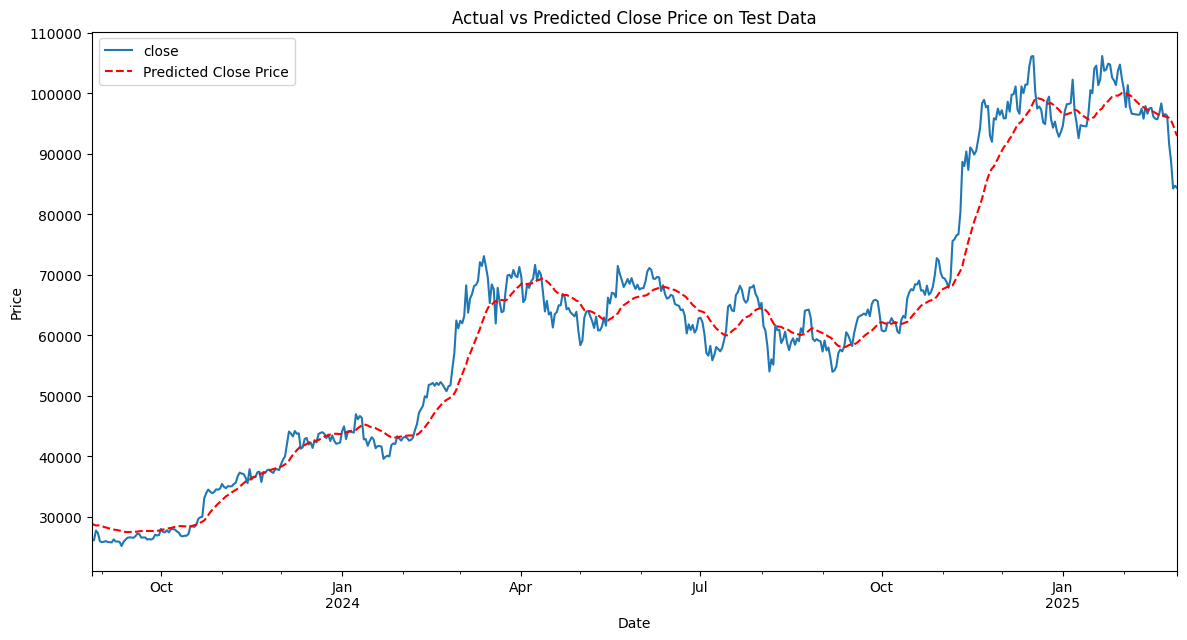

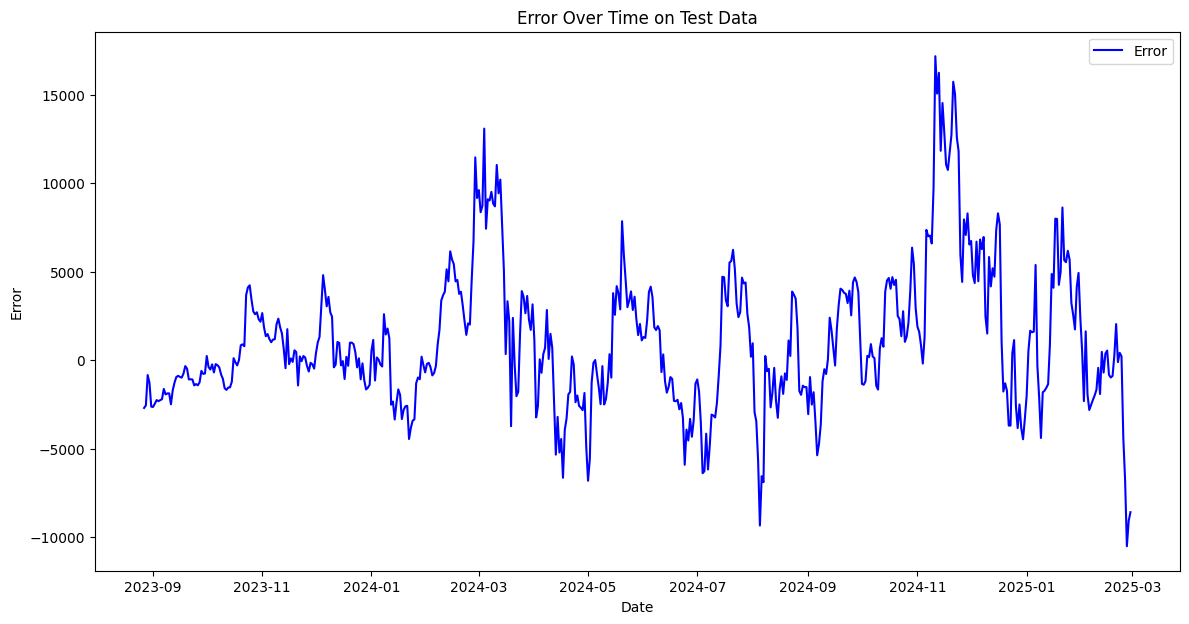

In [24]:
# Predict on the training data
train_predictions = elastic_pipeline.predict(train_x_imputed)

# Plot the actual vs predicted prices
plt.figure(figsize=(14, 7))
train_y = pd.to_numeric(train_y)
train_y.plot(figsize=(14, 7), title='Train Y - Actual Close Prices')
plt.plot(train.index, train_predictions, label='Predicted Close Price', color='red', linestyle='--')
plt.xlabel('Date')
plt.ylabel('Price')
plt.title('Actual vs Predicted Close Price on Training Data')
plt.legend()
plt.show()

# Plot the error over time for training data
train_error = train_y - train_predictions
plt.figure(figsize=(14, 7))
plt.plot(train.index, train_error, label='Error', color='blue')
plt.xlabel('Date')
plt.ylabel('Error')
plt.title('Error Over Time on Training Data')
plt.legend()
plt.show()

# Predict on the validation data
validate_predictions = elastic_pipeline.predict(validate_x_imputed)

plt.figure(figsize=(14, 7))
validate_y = pd.to_numeric(validate_y)
validate_y.plot(figsize=(14, 7))
plt.plot(validate.index, validate_predictions, label='Predicted Close Price', color='red', linestyle='--')
plt.xlabel('Date')
plt.ylabel('Price')
plt.title('Actual vs Predicted Close Price on Validation Data')
plt.legend()
plt.show()

# Plot the error over time for validation data
validate_error = validate_y - validate_predictions
plt.figure(figsize=(14, 7))
plt.plot(validate.index, validate_error, label='Error', color='blue')
plt.xlabel('Date')
plt.ylabel('Error')
plt.title('Error Over Time on Validation Data')
plt.legend()
plt.show()

# Predict on the test data
test_x_imputed = imputer.transform(test_x)
test_predictions = elastic_pipeline.predict(test_x_imputed)

plt.figure(figsize=(14, 7))
test_y = pd.to_numeric(test_y)
test_y.plot(figsize=(14, 7))
plt.plot(test.index, test_predictions, label='Predicted Close Price', color='red', linestyle='--')
plt.xlabel('Date')
plt.ylabel('Price')
plt.title('Actual vs Predicted Close Price on Test Data')
plt.legend()
plt.show()

# Plot the error over time for validation data
test_error = test_y - test_predictions
plt.figure(figsize=(14, 7))
plt.plot(test.index, test_error, label='Error', color='blue')
plt.xlabel('Date')
plt.ylabel('Error')
plt.title('Error Over Time on Test Data')
plt.legend()
plt.show()


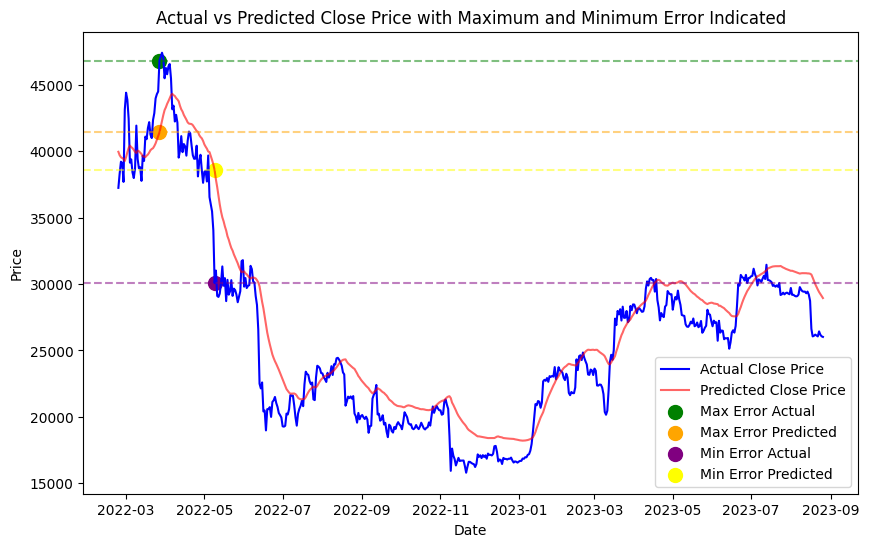

Max Error Date: 2022-03-27 00:00:00
Actual Close Price: 46827.76
Predicted Close Price: 41426.142781220165
Error: 5401.617218779837

Min Error Date: 2022-05-09 00:00:00
Actual Close Price: 30076.31
Predicted Close Price: 38585.64088564382
Error: -8509.33088564382


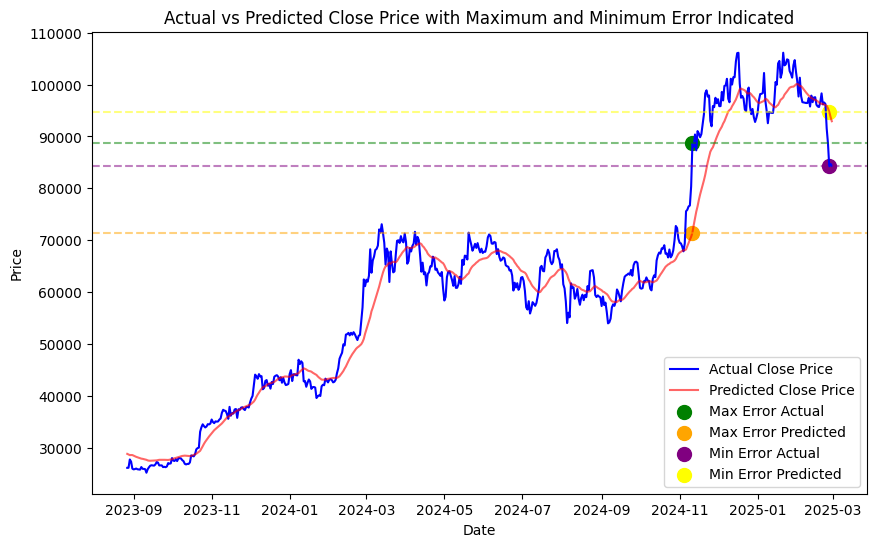

Max Error Date: 2024-11-11 00:00:00
Actual Close Price: 88647.99
Predicted Close Price: 71473.4087723606
Error: 17174.5812276394

Min Error Date: 2025-02-26 00:00:00
Actual Close Price: 84250.09
Predicted Close Price: 94757.53113156799
Error: -10507.44113156799


In [25]:
# Find the index of the maximum error
# Find the index of the maximum and minimum error
max_error_index = validate_error.idxmax()
min_error_index = validate_error.idxmin()

# Extract the corresponding values for maximum error
max_error_actual = validate_y.loc[max_error_index]
max_error_predicted = validate_predictions[validate_y.index.get_loc(max_error_index)]
max_error_value = validate_error[max_error_index]

# Extract the corresponding values for minimum error
min_error_actual = validate_y.loc[min_error_index]
min_error_predicted = validate_predictions[validate_y.index.get_loc(min_error_index)]
min_error_value = validate_error[min_error_index]

# Plot the scatter graph for maximum and minimum error
plt.figure(figsize=(10, 6))
plt.plot(validate_y.index, validate_y, label='Actual Close Price', color='blue')
plt.plot(validate_y.index, validate_predictions, label='Predicted Close Price', color='red', alpha=0.6)
plt.scatter(max_error_index, max_error_actual, color='green', s=100, label='Max Error Actual')
plt.scatter(max_error_index, max_error_predicted, color='orange', s=100, label='Max Error Predicted')
plt.scatter(min_error_index, min_error_actual, color='purple', s=100, label='Min Error Actual')
plt.scatter(min_error_index, min_error_predicted, color='yellow', s=100, label='Min Error Predicted')
plt.axhline(y=max_error_actual, color='green', linestyle='--', alpha=0.5)
plt.axhline(y=max_error_predicted, color='orange', linestyle='--', alpha=0.5)
plt.axhline(y=min_error_actual, color='purple', linestyle='--', alpha=0.5)
plt.axhline(y=min_error_predicted, color='yellow', linestyle='--', alpha=0.5)
plt.xlabel('Date')
plt.ylabel('Price')
plt.title('Actual vs Predicted Close Price with Maximum and Minimum Error Indicated')
plt.legend()
plt.show()

# Print the details of the maximum and minimum error
print(f'Max Error Date: {max_error_index}')
print(f'Actual Close Price: {max_error_actual}')
print(f'Predicted Close Price: {max_error_predicted}')
print(f'Error: {max_error_value}')

print(f'\nMin Error Date: {min_error_index}')
print(f'Actual Close Price: {min_error_actual}')
print(f'Predicted Close Price: {min_error_predicted}')
print(f'Error: {min_error_value}')

# Find the index of the maximum error
# Find the index of the maximum and minimum error
max_error_index = test_error.idxmax()
min_error_index = test_error.idxmin()

# Extract the corresponding values for maximum error
max_error_actual = test_y.loc[max_error_index]
max_error_predicted = test_predictions[test_y.index.get_loc(max_error_index)]
max_error_value = test_error[max_error_index]

# Extract the corresponding values for minimum error
min_error_actual = test_y.loc[min_error_index]
min_error_predicted = test_predictions[test_y.index.get_loc(min_error_index)]
min_error_value = test_error[min_error_index]

# Plot the scatter graph for maximum and minimum error
plt.figure(figsize=(10, 6))
plt.plot(test_y.index, test_y, label='Actual Close Price', color='blue')
plt.plot(test_y.index, test_predictions, label='Predicted Close Price', color='red', alpha=0.6)
plt.scatter(max_error_index, max_error_actual, color='green', s=100, label='Max Error Actual')
plt.scatter(max_error_index, max_error_predicted, color='orange', s=100, label='Max Error Predicted')
plt.scatter(min_error_index, min_error_actual, color='purple', s=100, label='Min Error Actual')
plt.scatter(min_error_index, min_error_predicted, color='yellow', s=100, label='Min Error Predicted')
plt.axhline(y=max_error_actual, color='green', linestyle='--', alpha=0.5)
plt.axhline(y=max_error_predicted, color='orange', linestyle='--', alpha=0.5)
plt.axhline(y=min_error_actual, color='purple', linestyle='--', alpha=0.5)
plt.axhline(y=min_error_predicted, color='yellow', linestyle='--', alpha=0.5)
plt.xlabel('Date')
plt.ylabel('Price')
plt.title('Actual vs Predicted Close Price with Maximum and Minimum Error Indicated')
plt.legend()
plt.show()

# Print the details of the maximum and minimum error
print(f'Max Error Date: {max_error_index}')
print(f'Actual Close Price: {max_error_actual}')
print(f'Predicted Close Price: {max_error_predicted}')
print(f'Error: {max_error_value}')

print(f'\nMin Error Date: {min_error_index}')
print(f'Actual Close Price: {min_error_actual}')
print(f'Predicted Close Price: {min_error_predicted}')
print(f'Error: {min_error_value}')